<a href="https://colab.research.google.com/github/ArkS0001/Kubernetes-Project-Telaverge/blob/main/server_client_deployement_%402.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install flask requests flask-ngrok

# 1. Server Code
from flask import Flask, request, jsonify
import threading
import time
from itertools import cycle

# Define Flask server
app1 = Flask("Server 1")
app2 = Flask("Server 2")

# Simulated workers (internal sub-services)
workers = ["Worker1", "Worker2", "Worker3"]
worker_iterator = cycle(workers)

# Round-robin processing
@app1.route('/process', methods=['POST'])
def process_server1():
    data = request.get_json()
    worker = next(worker_iterator)
    return jsonify({"server": "Server 1", "worker": worker, "message": data['message']})

@app2.route('/process', methods=['POST'])
def process_server2():
    data = request.get_json()
    worker = next(worker_iterator)
    return jsonify({"server": "Server 2", "worker": worker, "message": data['message']})

# Start servers on separate threads
def start_server1():
    app1.run(port=5001)

def start_server2():
    app2.run(port=5002)

threading.Thread(target=start_server1).start()
threading.Thread(target=start_server2).start()

time.sleep(3)  # Allow servers to start
print("Servers are running...")

# 2. Client Code
import requests
import itertools

# Simulated Kubernetes service endpoints
servers = ["http://127.0.0.1:5001/process", "http://127.0.0.1:5002/process"]
server_iterator = itertools.cycle(servers)

def send_request(message):
    server = next(server_iterator)
    try:
        response = requests.post(server, json={"message": message})
        print(response.json())
    except Exception as e:
        print(f"Error connecting to {server}: {e}")

# Simulate client sending requests in a round-robin manner
print("Client is sending requests...")
for i in range(10):
    send_request(f"Request {i + 1}")
    time.sleep(1)


 * Serving Flask app 'Server 1'
 * Debug mode: off
 * Serving Flask app 'Server 2'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5002
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit


Servers are running...


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:47] "POST /process HTTP/1.1" 200 -


Client is sending requests...
{'message': 'Request 1', 'server': 'Server 1', 'worker': 'Worker1'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:48] "POST /process HTTP/1.1" 200 -


{'message': 'Request 2', 'server': 'Server 2', 'worker': 'Worker2'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:49] "POST /process HTTP/1.1" 200 -


{'message': 'Request 3', 'server': 'Server 1', 'worker': 'Worker3'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:50] "POST /process HTTP/1.1" 200 -


{'message': 'Request 4', 'server': 'Server 2', 'worker': 'Worker1'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:51] "POST /process HTTP/1.1" 200 -


{'message': 'Request 5', 'server': 'Server 1', 'worker': 'Worker2'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:52] "POST /process HTTP/1.1" 200 -


{'message': 'Request 6', 'server': 'Server 2', 'worker': 'Worker3'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:53] "POST /process HTTP/1.1" 200 -


{'message': 'Request 7', 'server': 'Server 1', 'worker': 'Worker1'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:54] "POST /process HTTP/1.1" 200 -


{'message': 'Request 8', 'server': 'Server 2', 'worker': 'Worker2'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:55] "POST /process HTTP/1.1" 200 -


{'message': 'Request 9', 'server': 'Server 1', 'worker': 'Worker3'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:13:56] "POST /process HTTP/1.1" 200 -


{'message': 'Request 10', 'server': 'Server 2', 'worker': 'Worker1'}


In [2]:
!pip install flask flask-limiter requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.0 MB/s eta 0:00:00


In [4]:
from flask import Flask, request, jsonify
from flask_limiter import Limiter
from flask_limiter.util import get_remote_address
from itertools import cycle
import threading

# Initialize Flask apps
app1 = Flask("Server 1")
app2 = Flask("Server 2")

# Rate limiter (Redis backend can be added for distributed rate limiting)
limiter1 = Limiter(get_remote_address, app=app1, default_limits=["50 per second"])
limiter2 = Limiter(get_remote_address, app=app2, default_limits=["50 per second"])

# Simulated workers
workers = ["Worker1", "Worker2", "Worker3"]
worker_iterator = cycle(workers)

# Define server endpoints
@app1.route('/process', methods=['POST'])
@limiter1.limit("50 per second")  # Rate limit for Server 1
def process_server1():
    data = request.get_json()
    worker = next(worker_iterator)
    return jsonify({"server": "Server 1", "worker": worker, "message": data['message']}), 200

@app2.route('/process', methods=['POST'])
@limiter2.limit("50 per second")  # Rate limit for Server 2
def process_server2():
    data = request.get_json()
    worker = next(worker_iterator)
    return jsonify({"server": "Server 2", "worker": worker, "message": data['message']}), 200

# Start servers on separate threads
def start_server1():
    app1.run(port=5001)

def start_server2():
    app2.run(port=5002)

threading.Thread(target=start_server1).start()
threading.Thread(target=start_server2).start()


import requests
import itertools
import threading
import time

# Server endpoints (Simulating a Load Balancer distributing requests)
servers = ["http://127.0.0.1:5001/process", "http://127.0.0.1:5002/process"]
server_iterator = itertools.cycle(servers)

# Function to send requests
def send_request(message, request_id):
    server = next(server_iterator)
    try:
        response = requests.post(server, json={"message": message})
        print(f"Request {request_id}: {response.json()}")
    except Exception as e:
        print(f"Request {request_id} failed: {e}")

# Simulate 1000 requests/second using threading
def simulate_high_throughput(total_requests, concurrency):
    threads = []
    start_time = time.time()

    for i in range(total_requests):
        t = threading.Thread(target=send_request, args=(f"Message {i+1}", i+1))
        threads.append(t)
        t.start()

        # Control concurrency to approximately match 1000 requests/sec
        if (i + 1) % concurrency == 0:
            time.sleep(1)

    for t in threads:
        t.join()

    print(f"Total time taken: {time.time() - start_time} seconds")

# Simulate 1000 requests/second
simulate_high_throughput(total_requests=1000, concurrency=100)



 * Serving Flask app 'Server 1'


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -


 * Serving Flask app 'Server 2'
 * Debug mode: off
 * Debug mode: off


Address already in use
Port 5002 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "PO

Request 1: {'message': 'Message 1', 'server': 'Server 1', 'worker': 'Worker1'}
Request 2: {'message': 'Message 2', 'server': 'Server 2', 'worker': 'Worker2'}
Request 3: {'message': 'Message 3', 'server': 'Server 1', 'worker': 'Worker1'}
Request 4: {'message': 'Message 4', 'server': 'Server 2', 'worker': 'Worker3'}
Request 5: {'message': 'Message 5', 'server': 'Server 1', 'worker': 'Worker2'}
Request 7: {'message': 'Message 7', 'server': 'Server 1', 'worker': 'Worker3'}
Request 9: {'message': 'Message 9', 'server': 'Server 1', 'worker': 'Worker2'}
Request 6: {'message': 'Message 6', 'server': 'Server 2', 'worker': 'Worker1'}
Request 8: {'message': 'Message 8', 'server': 'Server 2', 'worker': 'Worker3'}
Request 10: {'message': 'Message 10', 'server': 'Server 2', 'worker': 'Worker1'}
Request 11: {'message': 'Message 11', 'server': 'Server 1', 'worker': 'Worker2'}
Request 13: {'message': 'Message 13', 'server': 'Server 1', 'worker': 'Worker3'}
Request 12: {'message': 'Message 12', 'server'

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -


Request 22: {'message': 'Message 22', 'server': 'Server 2', 'worker': 'Worker1'}
Request 23: {'message': 'Message 23', 'server': 'Server 1', 'worker': 'Worker2'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -


Request 24: {'message': 'Message 24', 'server': 'Server 2', 'worker': 'Worker3'}
Request 25: {'message': 'Message 25', 'server': 'Server 1', 'worker': 'Worker1'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 26: {'message': 'Message 26', 'server': 'Server 2', 'worker': 'Worker2'}
Request 27: {'message': 'Message 27', 'server': 'Server 1', 'worker': 'Worker3'}
Request 30: {'message': 'Message 30', 'server': 'Server 2', 'worker': 'Worker2'}
Request 28: {'message': 'Message 28', 'server': 'Server 2', 'worker': 'Worker1'}
Request 31: {'message': 'Message 31', 'server': 'Server 1', 'worker': 'Worker1'}
Request 29: {'message': 'Message 29', 'server': 'Server 1', 'worker': 'Worker3'}
Request 32: {'message': 'Message 32', 'server': 'Server 2', 'worker': 'Worker2'}
Request 34: {'message': 'Message 34', 'server': 'Server 2', 'worker': 'Worker3'}
Request 33: {'message': 'Message 33', 'server': 'Server 1', 'worker': 'Worker1'}
Request 38: {'message': 'Message 38', 'server': 'Server 2', 'worker': 'Worker2'}
Request 35: {'message': 'Message 35', 'server': 'Server 1', 'worker': 'Worker3'}
Request 37: {'message': 'Message 37', 'server': 'Server 1', 'worker': 'Worker1'}
Request 36: {'message': 'Mes

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -


Request 43: {'message': 'Message 43', 'server': 'Server 1', 'worker': 'Worker3'}
Request 45: {'message': 'Message 45', 'server': 'Server 1', 'worker': 'Worker1'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -


Request 47: {'message': 'Message 47', 'server': 'Server 1', 'worker': 'Worker2'}
Request 50: {'message': 'Message 50', 'server': 'Server 2', 'worker': 'Worker3'}
Request 49: {'message': 'Message 49', 'server': 'Server 1', 'worker': 'Worker1'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 48: {'message': 'Message 48', 'server': 'Server 2', 'worker': 'Worker2'}
Request 51: {'message': 'Message 51', 'server': 'Server 1', 'worker': 'Worker3'}
Request 52: {'message': 'Message 52', 'server': 'Server 2', 'worker': 'Worker1'}
Request 53: {'message': 'Message 53', 'server': 'Server 1', 'worker': 'Worker2'}
Request 54: {'message': 'Message 54', 'server': 'Server 2', 'worker': 'Worker1'}
Request 55: {'message': 'Message 55', 'server': 'Server 1', 'worker': 'Worker3'}
Request 57: {'message': 'Message 57', 'server': 'Server 1', 'worker': 'Worker2'}
Request 56: {'message': 'Message 56', 'server': 'Server 2', 'worker': 'Worker3'}
Request 58: {'message': 'Message 58', 'server': 'Server 2', 'worker': 'Worker1'}
Request 59: {'message': 'Message 59', 'server': 'Server 1', 'worker': 'Worker2'}
Request 60: {'message': 'Message 60', 'server': 'Server 2', 'worker': 'Worker3'}
Request 63: {'message': 'Message 63', 'server': 'Server 1', 'worker': 'Worker2'}
Request 62: {'message': 'Mes

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -


Request 69: {'message': 'Message 69', 'server': 'Server 1', 'worker': 'Worker2'}
Request 68: {'message': 'Message 68', 'server': 'Server 2', 'worker': 'Worker3'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -


Request 70: {'message': 'Message 70', 'server': 'Server 2', 'worker': 'Worker1'}
Request 71: {'message': 'Message 71', 'server': 'Server 1', 'worker': 'Worker3'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 72: {'message': 'Message 72', 'server': 'Server 2', 'worker': 'Worker2'}
Request 74: {'message': 'Message 74', 'server': 'Server 2', 'worker': 'Worker2'}
Request 75: {'message': 'Message 75', 'server': 'Server 1', 'worker': 'Worker1'}
Request 73: {'message': 'Message 73', 'server': 'Server 1', 'worker': 'Worker3'}
Request 76: {'message': 'Message 76', 'server': 'Server 2', 'worker': 'Worker1'}
Request 77: {'message': 'Message 77', 'server': 'Server 1', 'worker': 'Worker2'}
Request 79: {'message': 'Message 79', 'server': 'Server 1', 'worker': 'Worker3'}
Request 80: {'message': 'Message 80', 'server': 'Server 2', 'worker': 'Worker1'}
Request 78: {'message': 'Message 78', 'server': 'Server 2', 'worker': 'Worker2'}
Request 83: {'message': 'Message 83', 'server': 'Server 1', 'worker': 'Worker1'}
Request 82: {'message': 'Message 82', 'server': 'Server 2', 'worker': 'Worker3'}
Request 84: {'message': 'Message 84', 'server': 'Server 2', 'worker': 'Worker2'}
Request 81: {'message': 'Mes

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 102: {'message': 'Message 102', 'server': 'Server 2', 'worker': 'Worker2'}
Request 101: {'message': 'Message 101', 'server': 'Server 1', 'worker': 'Worker3'}
Request 104: {'message': 'Message 104', 'server': 'Server 2', 'worker': 'Worker1'}
Request 103: {'message': 'Message 103', 'server': 'Server 1', 'worker': 'Worker2'}
Request 105: {'message': 'Message 105', 'server': 'Server 1', 'worker': 'Worker3'}
Request 106: {'message': 'Message 106', 'server': 'Server 2', 'worker': 'Worker1'}
Request 108: {'message': 'Message 108', 'server': 'Server 2', 'worker': 'Worker3'}
Request 107: {'message': 'Message 107', 'server': 'Server 1', 'worker': 'Worker2'}
Request 110: {'message': 'Message 110', 'server': 'Server 2', 'worker': 'Worker2'}
Request 109: {'message': 'Message 109', 'server': 'Server 1', 'worker': 'Worker1'}
Request 111: {'message': 'Message 111', 'server': 'Server 1', 'worker': 'Worker3'}
Request 113: {'message': 'Message 113', 'server': 'Server 1', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 127: {'message': 'Message 127', 'server': 'Server 1', 'worker': 'Worker1'}
Request 128: {'message': 'Message 128', 'server': 'Server 2', 'worker': 'Worker2'}
Request 130: {'message': 'Message 130', 'server': 'Server 2', 'worker': 'Worker3'}
Request 129: {'message': 'Message 129', 'server': 'Server 1', 'worker': 'Worker1'}
Request 131: {'message': 'Message 131', 'server': 'Server 1', 'worker': 'Worker2'}
Request 133: {'message': 'Message 133', 'server': 'Server 1', 'worker': 'Worker3'}
Request 134: {'message': 'Message 134', 'server': 'Server 2', 'worker': 'Worker2'}
Request 132: {'message': 'Message 132', 'server': 'Server 2', 'worker': 'Worker1'}
Request 136: {'message': 'Message 136', 'server': 'Server 2', 'worker': 'Worker3'}
Request 135: {'message': 'Message 135', 'server': 'Server 1', 'worker': 'Worker1'}
Request 138: {'message': 'Message 138', 'server': 'Server 2', 'worker': 'Worker2'}
Request 139: {'message': 'Message 139', 'server': 'Server 1', 'worker': 'Worker3'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 149: {'message': 'Message 149', 'server': 'Server 1', 'worker': 'Worker2'}
Request 147: {'message': 'Message 147', 'server': 'Server 1', 'worker': 'Worker3'}
Request 150: {'message': 'Message 150', 'server': 'Server 2', 'worker': 'Worker1'}
Request 152: {'message': 'Message 152', 'server': 'Server 2', 'worker': 'Worker2'}
Request 154: {'message': 'Message 154', 'server': 'Server 2', 'worker': 'Worker3'}
Request 153: {'message': 'Message 153', 'server': 'Server 1', 'worker': 'Worker1'}
Request 156: {'message': 'Message 156', 'server': 'Server 2', 'worker': 'Worker2'}
Request 155: {'message': 'Message 155', 'server': 'Server 1', 'worker': 'Worker3'}
Request 158: {'message': 'Message 158', 'server': 'Server 2', 'worker': 'Worker1'}
Request 160: {'message': 'Message 160', 'server': 'Server 2', 'worker': 'Worker2'}
Request 157: {'message': 'Message 157', 'server': 'Server 1', 'worker': 'Worker3'}
Request 159: {'message': 'Message 159', 'server': 'Server 1', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 173: {'message': 'Message 173', 'server': 'Server 1', 'worker': 'Worker2'}
Request 174: {'message': 'Message 174', 'server': 'Server 2', 'worker': 'Worker3'}
Request 176: {'message': 'Message 176', 'server': 'Server 2', 'worker': 'Worker2'}
Request 177: {'message': 'Message 177', 'server': 'Server 1', 'worker': 'Worker1'}
Request 175: {'message': 'Message 175', 'server': 'Server 1', 'worker': 'Worker3'}
Request 178: {'message': 'Message 178', 'server': 'Server 2', 'worker': 'Worker1'}
Request 179: {'message': 'Message 179', 'server': 'Server 1', 'worker': 'Worker2'}
Request 181: {'message': 'Message 181', 'server': 'Server 1', 'worker': 'Worker3'}
Request 180: {'message': 'Message 180', 'server': 'Server 2', 'worker': 'Worker1'}
Request 182: {'message': 'Message 182', 'server': 'Server 2', 'worker': 'Worker3'}
Request 183: {'message': 'Message 183', 'server': 'Server 1', 'worker': 'Worker2'}
Request 185: {'message': 'Message 185', 'server': 'Server 1', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 202: {'message': 'Message 202', 'server': 'Server 2', 'worker': 'Worker3'}
Request 203: {'message': 'Message 203', 'server': 'Server 1', 'worker': 'Worker2'}
Request 201: {'message': 'Message 201', 'server': 'Server 1', 'worker': 'Worker1'}
Request 204: {'message': 'Message 204', 'server': 'Server 2', 'worker': 'Worker1'}
Request 205: {'message': 'Message 205', 'server': 'Server 1', 'worker': 'Worker3'}
Request 207: {'message': 'Message 207', 'server': 'Server 1', 'worker': 'Worker3'}
Request 206: {'message': 'Message 206', 'server': 'Server 2', 'worker': 'Worker2'}
Request 208: {'message': 'Message 208', 'server': 'Server 2', 'worker': 'Worker1'}
Request 210: {'message': 'Message 210', 'server': 'Server 2', 'worker': 'Worker2'}
Request 209: {'message': 'Message 209', 'server': 'Server 1', 'worker': 'Worker3'}
Request 211: {'message': 'Message 211', 'server': 'Server 1', 'worker': 'Worker1'}
Request 213: {'message': 'Message 213', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 221: {'message': 'Message 221', 'server': 'Server 1', 'worker': 'Worker3'}
Request 223: {'message': 'Message 223', 'server': 'Server 1', 'worker': 'Worker1'}
Request 224: {'message': 'Message 224', 'server': 'Server 2', 'worker': 'Worker2'}
Request 226: {'message': 'Message 226', 'server': 'Server 2', 'worker': 'Worker3'}
Request 225: {'message': 'Message 225', 'server': 'Server 1', 'worker': 'Worker1'}
Request 228: {'message': 'Message 228', 'server': 'Server 2', 'worker': 'Worker2'}
Request 230: {'message': 'Message 230', 'server': 'Server 2', 'worker': 'Worker3'}
Request 227: {'message': 'Message 227', 'server': 'Server 1', 'worker': 'Worker1'}
Request 231: {'message': 'Message 231', 'server': 'Server 1', 'worker': 'Worker3'}
Request 229: {'message': 'Message 229', 'server': 'Server 1', 'worker': 'Worker2'}
Request 232: {'message': 'Message 232', 'server': 'Server 2', 'worker': 'Worker1'}
Request 233: {'message': 'Message 233', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 253: {'message': 'Message 253', 'server': 'Server 1', 'worker': 'Worker1'}
Request 252: {'message': 'Message 252', 'server': 'Server 2', 'worker': 'Worker2'}
Request 256: {'message': 'Message 256', 'server': 'Server 2', 'worker': 'Worker3'}
Request 255: {'message': 'Message 255', 'server': 'Server 1', 'worker': 'Worker1'}
Request 257: {'message': 'Message 257', 'server': 'Server 1', 'worker': 'Worker2'}
Request 260: {'message': 'Message 260', 'server': 'Server 2', 'worker': 'Worker1'}
Request 258: {'message': 'Message 258', 'server': 'Server 2', 'worker': 'Worker3'}
Request 261: {'message': 'Message 261', 'server': 'Server 1', 'worker': 'Worker2'}
Request 259: {'message': 'Message 259', 'server': 'Server 1', 'worker': 'Worker3'}
Request 262: {'message': 'Message 262', 'server': 'Server 2', 'worker': 'Worker1'}
Request 263: {'message': 'Message 263', 'server': 'Server 1', 'worker': 'Worker2'}
Request 264: {'message': 'Message 264', 'server': 'Server 2', 'worker': 'Worker3'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 275: {'message': 'Message 275', 'server': 'Server 1', 'worker': 'Worker2'}
Request 276: {'message': 'Message 276', 'server': 'Server 2', 'worker': 'Worker3'}
Request 278: {'message': 'Message 278', 'server': 'Server 2', 'worker': 'Worker1'}
Request 277: {'message': 'Message 277', 'server': 'Server 1', 'worker': 'Worker2'}
Request 279: {'message': 'Message 279', 'server': 'Server 1', 'worker': 'Worker3'}
Request 281: {'message': 'Message 281', 'server': 'Server 1', 'worker': 'Worker2'}
Request 280: {'message': 'Message 280', 'server': 'Server 2', 'worker': 'Worker1'}
Request 283: {'message': 'Message 283', 'server': 'Server 1', 'worker': 'Worker3'}
Request 282: {'message': 'Message 282', 'server': 'Server 2', 'worker': 'Worker1'}
Request 285: {'message': 'Message 285', 'server': 'Server 1', 'worker': 'Worker2'}
Request 284: {'message': 'Message 284', 'server': 'Server 2', 'worker': 'Worker3'}
Request 286: {'message': 'Message 286', 'server': 'Server 2', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 302: {'message': 'Message 302', 'server': 'Server 2', 'worker': 'Worker1'}Request 301: {'message': 'Message 301', 'server': 'Server 1', 'worker': 'Worker2'}

Request 303: {'message': 'Message 303', 'server': 'Server 1', 'worker': 'Worker3'}
Request 305: {'message': 'Message 305', 'server': 'Server 1', 'worker': 'Worker1'}
Request 304: {'message': 'Message 304', 'server': 'Server 2', 'worker': 'Worker2'}
Request 306: {'message': 'Message 306', 'server': 'Server 2', 'worker': 'Worker3'}
Request 307: {'message': 'Message 307', 'server': 'Server 1', 'worker': 'Worker1'}
Request 308: {'message': 'Message 308', 'server': 'Server 2', 'worker': 'Worker2'}
Request 309: {'message': 'Message 309', 'server': 'Server 1', 'worker': 'Worker3'}
Request 310: {'message': 'Message 310', 'server': 'Server 2', 'worker': 'Worker1'}
Request 311: {'message': 'Message 311', 'server': 'Server 1', 'worker': 'Worker2'}
Request 312: {'message': 'Message 312', 'server': 'Server 2', 'worker': 'Worker3'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 322: {'message': 'Message 322', 'server': 'Server 2', 'worker': 'Worker2'}
Request 324: {'message': 'Message 324', 'server': 'Server 2', 'worker': 'Worker3'}
Request 325: {'message': 'Message 325', 'server': 'Server 1', 'worker': 'Worker1'}
Request 326: {'message': 'Message 326', 'server': 'Server 2', 'worker': 'Worker2'}
Request 327: {'message': 'Message 327', 'server': 'Server 1', 'worker': 'Worker3'}
Request 328: {'message': 'Message 328', 'server': 'Server 2', 'worker': 'Worker1'}
Request 329: {'message': 'Message 329', 'server': 'Server 1', 'worker': 'Worker2'}
Request 330: {'message': 'Message 330', 'server': 'Server 2', 'worker': 'Worker3'}
Request 331: {'message': 'Message 331', 'server': 'Server 1', 'worker': 'Worker1'}
Request 332: {'message': 'Message 332', 'server': 'Server 2', 'worker': 'Worker2'}
Request 333: {'message': 'Message 333', 'server': 'Server 1', 'worker': 'Worker3'}
Request 334: {'message': 'Message 334', 'server': 'Server 2', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 349: {'message': 'Message 349', 'server': 'Server 1', 'worker': 'Worker3'}
Request 348: {'message': 'Message 348', 'server': 'Server 2', 'worker': 'Worker1'}
Request 350: {'message': 'Message 350', 'server': 'Server 2', 'worker': 'Worker2'}
Request 351: {'message': 'Message 351', 'server': 'Server 1', 'worker': 'Worker3'}
Request 352: {'message': 'Message 352', 'server': 'Server 2', 'worker': 'Worker1'}
Request 353: {'message': 'Message 353', 'server': 'Server 1', 'worker': 'Worker2'}
Request 355: {'message': 'Message 355', 'server': 'Server 1', 'worker': 'Worker3'}
Request 354: {'message': 'Message 354', 'server': 'Server 2', 'worker': 'Worker1'}
Request 356: {'message': 'Message 356', 'server': 'Server 2', 'worker': 'Worker2'}
Request 357: {'message': 'Message 357', 'server': 'Server 1', 'worker': 'Worker3'}
Request 358: {'message': 'Message 358', 'server': 'Server 2', 'worker': 'Worker1'}
Request 359: {'message': 'Message 359', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 370: {'message': 'Message 370', 'server': 'Server 2', 'worker': 'Worker1'}
Request 372: {'message': 'Message 372', 'server': 'Server 2', 'worker': 'Worker2'}
Request 371: {'message': 'Message 371', 'server': 'Server 1', 'worker': 'Worker3'}
Request 373: {'message': 'Message 373', 'server': 'Server 1', 'worker': 'Worker1'}
Request 374: {'message': 'Message 374', 'server': 'Server 2', 'worker': 'Worker2'}
Request 375: {'message': 'Message 375', 'server': 'Server 1', 'worker': 'Worker3'}
Request 376: {'message': 'Message 376', 'server': 'Server 2', 'worker': 'Worker1'}
Request 377: {'message': 'Message 377', 'server': 'Server 1', 'worker': 'Worker2'}
Request 379: {'message': 'Message 379', 'server': 'Server 1', 'worker': 'Worker3'}
Request 378: {'message': 'Message 378', 'server': 'Server 2', 'worker': 'Worker1'}
Request 380: {'message': 'Message 380', 'server': 'Server 2', 'worker': 'Worker2'}
Request 381: {'message': 'Message 381', 'server': 'Server 1', 'worker': 'Worker3'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:46] "POST /process HTTP/1.1" 200 -


Request 392: {'message': 'Message 392', 'server': 'Server 2', 'worker': 'Worker2'}
Request 393: {'message': 'Message 393', 'server': 'Server 1', 'worker': 'Worker3'}
Request 394: {'message': 'Message 394', 'server': 'Server 2', 'worker': 'Worker1'}
Request 395: {'message': 'Message 395', 'server': 'Server 1', 'worker': 'Worker2'}
Request 396: {'message': 'Message 396', 'server': 'Server 2', 'worker': 'Worker3'}
Request 397: {'message': 'Message 397', 'server': 'Server 1', 'worker': 'Worker1'}
Request 398: {'message': 'Message 398', 'server': 'Server 2', 'worker': 'Worker2'}
Request 399: {'message': 'Message 399', 'server': 'Server 1', 'worker': 'Worker3'}
Request 400: {'message': 'Message 400', 'server': 'Server 2', 'worker': 'Worker1'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 401: {'message': 'Message 401', 'server': 'Server 1', 'worker': 'Worker2'}
Request 402: {'message': 'Message 402', 'server': 'Server 2', 'worker': 'Worker3'}
Request 403: {'message': 'Message 403', 'server': 'Server 1', 'worker': 'Worker2'}
Request 404: {'message': 'Message 404', 'server': 'Server 2', 'worker': 'Worker1'}
Request 405: {'message': 'Message 405', 'server': 'Server 1', 'worker': 'Worker3'}
Request 406: {'message': 'Message 406', 'server': 'Server 2', 'worker': 'Worker1'}
Request 408: {'message': 'Message 408', 'server': 'Server 2', 'worker': 'Worker3'}
Request 407: {'message': 'Message 407', 'server': 'Server 1', 'worker': 'Worker2'}
Request 409: {'message': 'Message 409', 'server': 'Server 1', 'worker': 'Worker1'}
Request 410: {'message': 'Message 410', 'server': 'Server 2', 'worker': 'Worker2'}
Request 411: {'message': 'Message 411', 'server': 'Server 1', 'worker': 'Worker3'}
Request 412: {'message': 'Message 412', 'server': 'Server 2', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 423: {'message': 'Message 423', 'server': 'Server 1', 'worker': 'Worker3'}
Request 425: {'message': 'Message 425', 'server': 'Server 1', 'worker': 'Worker1'}
Request 424: {'message': 'Message 424', 'server': 'Server 2', 'worker': 'Worker2'}
Request 426: {'message': 'Message 426', 'server': 'Server 2', 'worker': 'Worker3'}
Request 427: {'message': 'Message 427', 'server': 'Server 1', 'worker': 'Worker1'}
Request 428: {'message': 'Message 428', 'server': 'Server 2', 'worker': 'Worker2'}
Request 429: {'message': 'Message 429', 'server': 'Server 1', 'worker': 'Worker3'}Request 431: {'message': 'Message 431', 'server': 'Server 1', 'worker': 'Worker1'}

Request 430: {'message': 'Message 430', 'server': 'Server 2', 'worker': 'Worker2'}
Request 432: {'message': 'Message 432', 'server': 'Server 2', 'worker': 'Worker3'}
Request 433: {'message': 'Message 433', 'server': 'Server 1', 'worker': 'Worker1'}
Request 435: {'message': 'Message 435', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 447: {'message': 'Message 447', 'server': 'Server 1', 'worker': 'Worker3'}
Request 448: {'message': 'Message 448', 'server': 'Server 2', 'worker': 'Worker1'}
Request 449: {'message': 'Message 449', 'server': 'Server 1', 'worker': 'Worker2'}
Request 451: {'message': 'Message 451', 'server': 'Server 1', 'worker': 'Worker3'}
Request 453: {'message': 'Message 453', 'server': 'Server 1', 'worker': 'Worker1'}
Request 450: {'message': 'Message 450', 'server': 'Server 2', 'worker': 'Worker2'}
Request 452: {'message': 'Message 452', 'server': 'Server 2', 'worker': 'Worker3'}
Request 455: {'message': 'Message 455', 'server': 'Server 1', 'worker': 'Worker1'}
Request 454: {'message': 'Message 454', 'server': 'Server 2', 'worker': 'Worker2'}
Request 456: {'message': 'Message 456', 'server': 'Server 2', 'worker': 'Worker3'}
Request 457: {'message': 'Message 457', 'server': 'Server 1', 'worker': 'Worker1'}
Request 458: {'message': 'Message 458', 'server': 'Server 2', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 469: {'message': 'Message 469', 'server': 'Server 1', 'worker': 'Worker1'}
Request 470: {'message': 'Message 470', 'server': 'Server 2', 'worker': 'Worker2'}
Request 471: {'message': 'Message 471', 'server': 'Server 1', 'worker': 'Worker3'}
Request 472: {'message': 'Message 472', 'server': 'Server 2', 'worker': 'Worker1'}
Request 473: {'message': 'Message 473', 'server': 'Server 1', 'worker': 'Worker2'}
Request 474: {'message': 'Message 474', 'server': 'Server 2', 'worker': 'Worker3'}
Request 475: {'message': 'Message 475', 'server': 'Server 1', 'worker': 'Worker1'}
Request 476: {'message': 'Message 476', 'server': 'Server 2', 'worker': 'Worker2'}
Request 477: {'message': 'Message 477', 'server': 'Server 1', 'worker': 'Worker3'}
Request 478: {'message': 'Message 478', 'server': 'Server 2', 'worker': 'Worker1'}
Request 479: {'message': 'Message 479', 'server': 'Server 1', 'worker': 'Worker2'}
Request 480: {'message': 'Message 480', 'server': 'Server 2', 'worker': 'Worker3'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 488: {'message': 'Message 488', 'server': 'Server 2', 'worker': 'Worker2'}
Request 489: {'message': 'Message 489', 'server': 'Server 1', 'worker': 'Worker3'}
Request 490: {'message': 'Message 490', 'server': 'Server 2', 'worker': 'Worker1'}
Request 491: {'message': 'Message 491', 'server': 'Server 1', 'worker': 'Worker2'}
Request 492: {'message': 'Message 492', 'server': 'Server 2', 'worker': 'Worker3'}
Request 493: {'message': 'Message 493', 'server': 'Server 1', 'worker': 'Worker1'}
Request 494: {'message': 'Message 494', 'server': 'Server 2', 'worker': 'Worker2'}
Request 496: {'message': 'Message 496', 'server': 'Server 2', 'worker': 'Worker3'}
Request 495: {'message': 'Message 495', 'server': 'Server 1', 'worker': 'Worker1'}
Request 498: {'message': 'Message 498', 'server': 'Server 2', 'worker': 'Worker2'}
Request 497: {'message': 'Message 497', 'server': 'Server 1', 'worker': 'Worker3'}
Request 499: {'message': 'Message 499', 'server': 'Server 1', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 501: {'message': 'Message 501', 'server': 'Server 1', 'worker': 'Worker3'}
Request 502: {'message': 'Message 502', 'server': 'Server 2', 'worker': 'Worker1'}
Request 504: {'message': 'Message 504', 'server': 'Server 2', 'worker': 'Worker2'}Request 503: {'message': 'Message 503', 'server': 'Server 1', 'worker': 'Worker3'}

Request 505: {'message': 'Message 505', 'server': 'Server 1', 'worker': 'Worker1'}
Request 506: {'message': 'Message 506', 'server': 'Server 2', 'worker': 'Worker2'}
Request 507: {'message': 'Message 507', 'server': 'Server 1', 'worker': 'Worker3'}
Request 508: {'message': 'Message 508', 'server': 'Server 2', 'worker': 'Worker1'}
Request 511: {'message': 'Message 511', 'server': 'Server 1', 'worker': 'Worker2'}
Request 510: {'message': 'Message 510', 'server': 'Server 2', 'worker': 'Worker3'}
Request 509: {'message': 'Message 509', 'server': 'Server 1', 'worker': 'Worker1'}
Request 512: {'message': 'Message 512', 'server': 'Server 2', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 521: {'message': 'Message 521', 'server': 'Server 1', 'worker': 'Worker2'}
Request 522: {'message': 'Message 522', 'server': 'Server 2', 'worker': 'Worker3'}
Request 523: {'message': 'Message 523', 'server': 'Server 1', 'worker': 'Worker1'}
Request 524: {'message': 'Message 524', 'server': 'Server 2', 'worker': 'Worker2'}
Request 525: {'message': 'Message 525', 'server': 'Server 1', 'worker': 'Worker3'}
Request 526: {'message': 'Message 526', 'server': 'Server 2', 'worker': 'Worker1'}
Request 527: {'message': 'Message 527', 'server': 'Server 1', 'worker': 'Worker2'}
Request 528: {'message': 'Message 528', 'server': 'Server 2', 'worker': 'Worker3'}
Request 530: {'message': 'Message 530', 'server': 'Server 2', 'worker': 'Worker1'}
Request 529: {'message': 'Message 529', 'server': 'Server 1', 'worker': 'Worker2'}
Request 531: {'message': 'Message 531', 'server': 'Server 1', 'worker': 'Worker3'}
Request 533: {'message': 'Message 533', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 545: {'message': 'Message 545', 'server': 'Server 1', 'worker': 'Worker2'}
Request 546: {'message': 'Message 546', 'server': 'Server 2', 'worker': 'Worker3'}
Request 547: {'message': 'Message 547', 'server': 'Server 1', 'worker': 'Worker1'}
Request 548: {'message': 'Message 548', 'server': 'Server 2', 'worker': 'Worker2'}
Request 549: {'message': 'Message 549', 'server': 'Server 1', 'worker': 'Worker3'}
Request 550: {'message': 'Message 550', 'server': 'Server 2', 'worker': 'Worker1'}
Request 552: {'message': 'Message 552', 'server': 'Server 2', 'worker': 'Worker2'}
Request 551: {'message': 'Message 551', 'server': 'Server 1', 'worker': 'Worker3'}
Request 553: {'message': 'Message 553', 'server': 'Server 1', 'worker': 'Worker1'}
Request 554: {'message': 'Message 554', 'server': 'Server 2', 'worker': 'Worker2'}
Request 555: {'message': 'Message 555', 'server': 'Server 1', 'worker': 'Worker3'}
Request 558: {'message': 'Message 558', 'server': 'Server 2', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 564: {'message': 'Message 564', 'server': 'Server 2', 'worker': 'Worker3'}
Request 565: {'message': 'Message 565', 'server': 'Server 1', 'worker': 'Worker1'}
Request 566: {'message': 'Message 566', 'server': 'Server 2', 'worker': 'Worker2'}
Request 567: {'message': 'Message 567', 'server': 'Server 1', 'worker': 'Worker3'}
Request 569: {'message': 'Message 569', 'server': 'Server 1', 'worker': 'Worker1'}
Request 568: {'message': 'Message 568', 'server': 'Server 2', 'worker': 'Worker2'}
Request 570: {'message': 'Message 570', 'server': 'Server 2', 'worker': 'Worker3'}
Request 571: {'message': 'Message 571', 'server': 'Server 1', 'worker': 'Worker1'}
Request 573: {'message': 'Message 573', 'server': 'Server 1', 'worker': 'Worker3'}
Request 572: {'message': 'Message 572', 'server': 'Server 2', 'worker': 'Worker2'}
Request 574: {'message': 'Message 574', 'server': 'Server 2', 'worker': 'Worker1'}
Request 575: {'message': 'Message 575', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 584: {'message': 'Message 584', 'server': 'Server 2', 'worker': 'Worker2'}
Request 585: {'message': 'Message 585', 'server': 'Server 1', 'worker': 'Worker3'}
Request 587: {'message': 'Message 587', 'server': 'Server 1', 'worker': 'Worker1'}
Request 586: {'message': 'Message 586', 'server': 'Server 2', 'worker': 'Worker2'}
Request 588: {'message': 'Message 588', 'server': 'Server 2', 'worker': 'Worker3'}
Request 590: {'message': 'Message 590', 'server': 'Server 2', 'worker': 'Worker1'}
Request 589: {'message': 'Message 589', 'server': 'Server 1', 'worker': 'Worker2'}
Request 591: {'message': 'Message 591', 'server': 'Server 1', 'worker': 'Worker3'}
Request 592: {'message': 'Message 592', 'server': 'Server 2', 'worker': 'Worker1'}
Request 593: {'message': 'Message 593', 'server': 'Server 1', 'worker': 'Worker2'}
Request 594: {'message': 'Message 594', 'server': 'Server 2', 'worker': 'Worker3'}
Request 596: {'message': 'Message 596', 'server': 'Server 2', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 601: {'message': 'Message 601', 'server': 'Server 1', 'worker': 'Worker2'}
Request 602: {'message': 'Message 602', 'server': 'Server 2', 'worker': 'Worker1'}
Request 603: {'message': 'Message 603', 'server': 'Server 1', 'worker': 'Worker3'}
Request 604: {'message': 'Message 604', 'server': 'Server 2', 'worker': 'Worker1'}
Request 605: {'message': 'Message 605', 'server': 'Server 1', 'worker': 'Worker2'}
Request 606: {'message': 'Message 606', 'server': 'Server 2', 'worker': 'Worker3'}
Request 607: {'message': 'Message 607', 'server': 'Server 1', 'worker': 'Worker1'}
Request 608: {'message': 'Message 608', 'server': 'Server 2', 'worker': 'Worker2'}
Request 611: {'message': 'Message 611', 'server': 'Server 1', 'worker': 'Worker1'}
Request 609: {'message': 'Message 609', 'server': 'Server 1', 'worker': 'Worker3'}
Request 612: {'message': 'Message 612', 'server': 'Server 2', 'worker': 'Worker2'}
Request 610: {'message': 'Message 610', 'server': 'Server 2', 'worker': 'Worker3'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 624: {'message': 'Message 624', 'server': 'Server 2', 'worker': 'Worker2'}
Request 625: {'message': 'Message 625', 'server': 'Server 1', 'worker': 'Worker3'}
Request 626: {'message': 'Message 626', 'server': 'Server 2', 'worker': 'Worker2'}
Request 627: {'message': 'Message 627', 'server': 'Server 1', 'worker': 'Worker3'}
Request 628: {'message': 'Message 628', 'server': 'Server 2', 'worker': 'Worker1'}
Request 630: {'message': 'Message 630', 'server': 'Server 2', 'worker': 'Worker3'}
Request 629: {'message': 'Message 629', 'server': 'Server 1', 'worker': 'Worker2'}
Request 631: {'message': 'Message 631', 'server': 'Server 1', 'worker': 'Worker1'}
Request 632: {'message': 'Message 632', 'server': 'Server 2', 'worker': 'Worker2'}
Request 633: {'message': 'Message 633', 'server': 'Server 1', 'worker': 'Worker3'}
Request 635: {'message': 'Message 635', 'server': 'Server 1', 'worker': 'Worker2'}
Request 634: {'message': 'Message 634', 'server': 'Server 2', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 649: {'message': 'Message 649', 'server': 'Server 1', 'worker': 'Worker1'}
Request 651: {'message': 'Message 651', 'server': 'Server 1', 'worker': 'Worker3'}
Request 652: {'message': 'Message 652', 'server': 'Server 2', 'worker': 'Worker1'}
Request 653: {'message': 'Message 653', 'server': 'Server 1', 'worker': 'Worker2'}
Request 654: {'message': 'Message 654', 'server': 'Server 2', 'worker': 'Worker3'}
Request 656: {'message': 'Message 656', 'server': 'Server 2', 'worker': 'Worker1'}
Request 655: {'message': 'Message 655', 'server': 'Server 1', 'worker': 'Worker2'}
Request 658: {'message': 'Message 658', 'server': 'Server 2', 'worker': 'Worker1'}
Request 657: {'message': 'Message 657', 'server': 'Server 1', 'worker': 'Worker3'}
Request 659: {'message': 'Message 659', 'server': 'Server 1', 'worker': 'Worker2'}
Request 661: {'message': 'Message 661', 'server': 'Server 1', 'worker': 'Worker3'}
Request 660: {'message': 'Message 660', 'server': 'Server 2', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 674: {'message': 'Message 674', 'server': 'Server 2', 'worker': 'Worker3'}
Request 675: {'message': 'Message 675', 'server': 'Server 1', 'worker': 'Worker1'}
Request 672: {'message': 'Message 672', 'server': 'Server 2', 'worker': 'Worker2'}
Request 676: {'message': 'Message 676', 'server': 'Server 2', 'worker': 'Worker3'}
Request 673: {'message': 'Message 673', 'server': 'Server 1', 'worker': 'Worker1'}
Request 677: {'message': 'Message 677', 'server': 'Server 1', 'worker': 'Worker2'}
Request 678: {'message': 'Message 678', 'server': 'Server 2', 'worker': 'Worker3'}
Request 679: {'message': 'Message 679', 'server': 'Server 1', 'worker': 'Worker1'}
Request 680: {'message': 'Message 680', 'server': 'Server 2', 'worker': 'Worker2'}
Request 681: {'message': 'Message 681', 'server': 'Server 1', 'worker': 'Worker3'}
Request 683: {'message': 'Message 683', 'server': 'Server 1', 'worker': 'Worker1'}
Request 682: {'message': 'Message 682', 'server': 'Server 2', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:52] "POST /process HTTP/1.1" 200 -


Request 691: {'message': 'Message 691', 'server': 'Server 1', 'worker': 'Worker2'}
Request 694: {'message': 'Message 694', 'server': 'Server 2', 'worker': 'Worker3'}
Request 693: {'message': 'Message 693', 'server': 'Server 1', 'worker': 'Worker1'}
Request 695: {'message': 'Message 695', 'server': 'Server 1', 'worker': 'Worker2'}
Request 690: {'message': 'Message 690', 'server': 'Server 2', 'worker': 'Worker2'}
Request 698: {'message': 'Message 698', 'server': 'Server 2', 'worker': 'Worker1'}
Request 697: {'message': 'Message 697', 'server': 'Server 1', 'worker': 'Worker2'}
Request 699: {'message': 'Message 699', 'server': 'Server 1', 'worker': 'Worker3'}
Request 700: {'message': 'Message 700', 'server': 'Server 2', 'worker': 'Worker1'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 701: {'message': 'Message 701', 'server': 'Server 1', 'worker': 'Worker2'}
Request 703: {'message': 'Message 703', 'server': 'Server 1', 'worker': 'Worker3'}
Request 702: {'message': 'Message 702', 'server': 'Server 2', 'worker': 'Worker1'}
Request 704: {'message': 'Message 704', 'server': 'Server 2', 'worker': 'Worker2'}
Request 706: {'message': 'Message 706', 'server': 'Server 2', 'worker': 'Worker3'}
Request 705: {'message': 'Message 705', 'server': 'Server 1', 'worker': 'Worker1'}
Request 708: {'message': 'Message 708', 'server': 'Server 2', 'worker': 'Worker2'}
Request 707: {'message': 'Message 707', 'server': 'Server 1', 'worker': 'Worker3'}
Request 709: {'message': 'Message 709', 'server': 'Server 1', 'worker': 'Worker1'}
Request 710: {'message': 'Message 710', 'server': 'Server 2', 'worker': 'Worker2'}
Request 711: {'message': 'Message 711', 'server': 'Server 1', 'worker': 'Worker3'}
Request 712: {'message': 'Message 712', 'server': 'Server 2', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 726: {'message': 'Message 726', 'server': 'Server 2', 'worker': 'Worker1'}
Request 727: {'message': 'Message 727', 'server': 'Server 1', 'worker': 'Worker3'}
Request 724: {'message': 'Message 724', 'server': 'Server 2', 'worker': 'Worker2'}
Request 729: {'message': 'Message 729', 'server': 'Server 1', 'worker': 'Worker2'}
Request 728: {'message': 'Message 728', 'server': 'Server 2', 'worker': 'Worker3'}
Request 731: {'message': 'Message 731', 'server': 'Server 1', 'worker': 'Worker1'}
Request 730: {'message': 'Message 730', 'server': 'Server 2', 'worker': 'Worker2'}
Request 732: {'message': 'Message 732', 'server': 'Server 2', 'worker': 'Worker3'}
Request 733: {'message': 'Message 733', 'server': 'Server 1', 'worker': 'Worker1'}
Request 735: {'message': 'Message 735', 'server': 'Server 1', 'worker': 'Worker2'}Request 734: {'message': 'Message 734', 'server': 'Server 2', 'worker': 'Worker3'}

Request 737: {'message': 'Message 737', 'server': 'Server 1', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 750: {'message': 'Message 750', 'server': 'Server 2', 'worker': 'Worker3'}
Request 751: {'message': 'Message 751', 'server': 'Server 1', 'worker': 'Worker1'}
Request 752: {'message': 'Message 752', 'server': 'Server 2', 'worker': 'Worker2'}
Request 754: {'message': 'Message 754', 'server': 'Server 2', 'worker': 'Worker3'}
Request 753: {'message': 'Message 753', 'server': 'Server 1', 'worker': 'Worker1'}
Request 755: {'message': 'Message 755', 'server': 'Server 1', 'worker': 'Worker2'}
Request 757: {'message': 'Message 757', 'server': 'Server 1', 'worker': 'Worker3'}
Request 756: {'message': 'Message 756', 'server': 'Server 2', 'worker': 'Worker1'}
Request 758: {'message': 'Message 758', 'server': 'Server 2', 'worker': 'Worker2'}
Request 760: {'message': 'Message 760', 'server': 'Server 2', 'worker': 'Worker3'}
Request 759: {'message': 'Message 759', 'server': 'Server 1', 'worker': 'Worker1'}
Request 761: {'message': 'Message 761', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 783: {'message': 'Message 783', 'server': 'Server 1', 'worker': 'Worker3'}
Request 784: {'message': 'Message 784', 'server': 'Server 2', 'worker': 'Worker1'}
Request 785: {'message': 'Message 785', 'server': 'Server 1', 'worker': 'Worker2'}
Request 786: {'message': 'Message 786', 'server': 'Server 2', 'worker': 'Worker3'}
Request 788: {'message': 'Message 788', 'server': 'Server 2', 'worker': 'Worker2'}
Request 787: {'message': 'Message 787', 'server': 'Server 1', 'worker': 'Worker1'}
Request 789: {'message': 'Message 789', 'server': 'Server 1', 'worker': 'Worker3'}
Request 792: {'message': 'Message 792', 'server': 'Server 2', 'worker': 'Worker2'}
Request 790: {'message': 'Message 790', 'server': 'Server 2', 'worker': 'Worker1'}
Request 791: {'message': 'Message 791', 'server': 'Server 1', 'worker': 'Worker3'}
Request 794: {'message': 'Message 794', 'server': 'Server 2', 'worker': 'Worker1'}
Request 793: {'message': 'Message 793', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 801: {'message': 'Message 801', 'server': 'Server 1', 'worker': 'Worker3'}
Request 802: {'message': 'Message 802', 'server': 'Server 2', 'worker': 'Worker1'}
Request 804: {'message': 'Message 804', 'server': 'Server 2', 'worker': 'Worker2'}
Request 803: {'message': 'Message 803', 'server': 'Server 1', 'worker': 'Worker3'}
Request 805: {'message': 'Message 805', 'server': 'Server 1', 'worker': 'Worker1'}
Request 806: {'message': 'Message 806', 'server': 'Server 2', 'worker': 'Worker2'}
Request 808: {'message': 'Message 808', 'server': 'Server 2', 'worker': 'Worker3'}
Request 807: {'message': 'Message 807', 'server': 'Server 1', 'worker': 'Worker1'}
Request 810: {'message': 'Message 810', 'server': 'Server 2', 'worker': 'Worker2'}
Request 813: {'message': 'Message 813', 'server': 'Server 1', 'worker': 'Worker3'}
Request 811: {'message': 'Message 811', 'server': 'Server 1', 'worker': 'Worker1'}
Request 812: {'message': 'Message 812', 'server': 'Server 2', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 830: {'message': 'Message 830', 'server': 'Server 2', 'worker': 'Worker1'}
Request 829: {'message': 'Message 829', 'server': 'Server 1', 'worker': 'Worker2'}
Request 832: {'message': 'Message 832', 'server': 'Server 2', 'worker': 'Worker3'}
Request 831: {'message': 'Message 831', 'server': 'Server 1', 'worker': 'Worker1'}
Request 833: {'message': 'Message 833', 'server': 'Server 1', 'worker': 'Worker2'}
Request 834: {'message': 'Message 834', 'server': 'Server 2', 'worker': 'Worker3'}
Request 835: {'message': 'Message 835', 'server': 'Server 1', 'worker': 'Worker1'}
Request 836: {'message': 'Message 836', 'server': 'Server 2', 'worker': 'Worker2'}
Request 837: {'message': 'Message 837', 'server': 'Server 1', 'worker': 'Worker3'}
Request 838: {'message': 'Message 838', 'server': 'Server 2', 'worker': 'Worker1'}
Request 839: {'message': 'Message 839', 'server': 'Server 1', 'worker': 'Worker2'}
Request 842: {'message': 'Message 842', 'server': 'Server 2', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 854: {'message': 'Message 854', 'server': 'Server 2', 'worker': 'Worker1'}
Request 853: {'message': 'Message 853', 'server': 'Server 1', 'worker': 'Worker2'}
Request 855: {'message': 'Message 855', 'server': 'Server 1', 'worker': 'Worker3'}
Request 856: {'message': 'Message 856', 'server': 'Server 2', 'worker': 'Worker1'}
Request 857: {'message': 'Message 857', 'server': 'Server 1', 'worker': 'Worker2'}
Request 858: {'message': 'Message 858', 'server': 'Server 2', 'worker': 'Worker3'}
Request 859: {'message': 'Message 859', 'server': 'Server 1', 'worker': 'Worker1'}
Request 860: {'message': 'Message 860', 'server': 'Server 2', 'worker': 'Worker2'}
Request 861: {'message': 'Message 861', 'server': 'Server 1', 'worker': 'Worker3'}
Request 862: {'message': 'Message 862', 'server': 'Server 2', 'worker': 'Worker1'}
Request 863: {'message': 'Message 863', 'server': 'Server 1', 'worker': 'Worker2'}
Request 864: {'message': 'Message 864', 'server': 'Server 2', 'worker': 'Worker3'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 870: {'message': 'Message 870', 'server': 'Server 2', 'worker': 'Worker3'}
Request 867: {'message': 'Message 867', 'server': 'Server 1', 'worker': 'Worker1'}
Request 871: {'message': 'Message 871', 'server': 'Server 1', 'worker': 'Worker1'}
Request 872: {'message': 'Message 872', 'server': 'Server 2', 'worker': 'Worker2'}
Request 874: {'message': 'Message 874', 'server': 'Server 2', 'worker': 'Worker1'}
Request 876: {'message': 'Message 876', 'server': 'Server 2', 'worker': 'Worker2'}
Request 875: {'message': 'Message 875', 'server': 'Server 1', 'worker': 'Worker3'}
Request 877: {'message': 'Message 877', 'server': 'Server 1', 'worker': 'Worker1'}
Request 879: {'message': 'Message 879', 'server': 'Server 1', 'worker': 'Worker3'}
Request 878: {'message': 'Message 878', 'server': 'Server 2', 'worker': 'Worker2'}
Request 880: {'message': 'Message 880', 'server': 'Server 2', 'worker': 'Worker1'}
Request 881: {'message': 'Message 881', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:56] "POST /process HTTP/1.1" 200 -


Request 895: {'message': 'Message 895', 'server': 'Server 1', 'worker': 'Worker2'}
Request 896: {'message': 'Message 896', 'server': 'Server 2', 'worker': 'Worker1'}
Request 897: {'message': 'Message 897', 'server': 'Server 1', 'worker': 'Worker3'}
Request 898: {'message': 'Message 898', 'server': 'Server 2', 'worker': 'Worker1'}
Request 899: {'message': 'Message 899', 'server': 'Server 1', 'worker': 'Worker2'}
Request 900: {'message': 'Message 900', 'server': 'Server 2', 'worker': 'Worker3'}


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 901: {'message': 'Message 901', 'server': 'Server 1', 'worker': 'Worker1'}
Request 902: {'message': 'Message 902', 'server': 'Server 2', 'worker': 'Worker2'}
Request 903: {'message': 'Message 903', 'server': 'Server 1', 'worker': 'Worker3'}
Request 904: {'message': 'Message 904', 'server': 'Server 2', 'worker': 'Worker1'}
Request 905: {'message': 'Message 905', 'server': 'Server 1', 'worker': 'Worker2'}
Request 906: {'message': 'Message 906', 'server': 'Server 2', 'worker': 'Worker3'}
Request 908: {'message': 'Message 908', 'server': 'Server 2', 'worker': 'Worker1'}
Request 907: {'message': 'Message 907', 'server': 'Server 1', 'worker': 'Worker2'}
Request 909: {'message': 'Message 909', 'server': 'Server 1', 'worker': 'Worker3'}
Request 910: {'message': 'Message 910', 'server': 'Server 2', 'worker': 'Worker1'}
Request 911: {'message': 'Message 911', 'server': 'Server 1', 'worker': 'Worker2'}
Request 912: {'message': 'Message 912', 'server': 'Server 2', 'worker': 'Worker3'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 923: {'message': 'Message 923', 'server': 'Server 1', 'worker': 'Worker2'}
Request 924: {'message': 'Message 924', 'server': 'Server 2', 'worker': 'Worker3'}
Request 925: {'message': 'Message 925', 'server': 'Server 1', 'worker': 'Worker1'}
Request 926: {'message': 'Message 926', 'server': 'Server 2', 'worker': 'Worker2'}
Request 927: {'message': 'Message 927', 'server': 'Server 1', 'worker': 'Worker3'}
Request 928: {'message': 'Message 928', 'server': 'Server 2', 'worker': 'Worker1'}
Request 930: {'message': 'Message 930', 'server': 'Server 2', 'worker': 'Worker2'}
Request 931: {'message': 'Message 931', 'server': 'Server 1', 'worker': 'Worker3'}
Request 929: {'message': 'Message 929', 'server': 'Server 1', 'worker': 'Worker1'}
Request 932: {'message': 'Message 932', 'server': 'Server 2', 'worker': 'Worker2'}
Request 933: {'message': 'Message 933', 'server': 'Server 1', 'worker': 'Worker3'}
Request 935: {'message': 'Message 935', 'server': 'Server 1', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 949: {'message': 'Message 949', 'server': 'Server 1', 'worker': 'Worker3'}
Request 948: {'message': 'Message 948', 'server': 'Server 2', 'worker': 'Worker1'}
Request 951: {'message': 'Message 951', 'server': 'Server 1', 'worker': 'Worker2'}
Request 950: {'message': 'Message 950', 'server': 'Server 2', 'worker': 'Worker3'}
Request 952: {'message': 'Message 952', 'server': 'Server 2', 'worker': 'Worker1'}
Request 953: {'message': 'Message 953', 'server': 'Server 1', 'worker': 'Worker2'}
Request 954: {'message': 'Message 954', 'server': 'Server 2', 'worker': 'Worker3'}
Request 955: {'message': 'Message 955', 'server': 'Server 1', 'worker': 'Worker1'}
Request 957: {'message': 'Message 957', 'server': 'Server 1', 'worker': 'Worker3'}
Request 956: {'message': 'Message 956', 'server': 'Server 2', 'worker': 'Worker2'}
Request 958: {'message': 'Message 958', 'server': 'Server 2', 'worker': 'Worker1'}
Request 959: {'message': 'Message 959', 'server': 'Server 1', 'worker': 'Worker2'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 971: {'message': 'Message 971', 'server': 'Server 1', 'worker': 'Worker2'}
Request 972: {'message': 'Message 972', 'server': 'Server 2', 'worker': 'Worker3'}
Request 973: {'message': 'Message 973', 'server': 'Server 1', 'worker': 'Worker1'}
Request 975: {'message': 'Message 975', 'server': 'Server 1', 'worker': 'Worker2'}
Request 974: {'message': 'Message 974', 'server': 'Server 2', 'worker': 'Worker3'}
Request 977: {'message': 'Message 977', 'server': 'Server 1', 'worker': 'Worker1'}
Request 979: {'message': 'Message 979', 'server': 'Server 1', 'worker': 'Worker2'}
Request 976: {'message': 'Message 976', 'server': 'Server 2', 'worker': 'Worker3'}
Request 978: {'message': 'Message 978', 'server': 'Server 2', 'worker': 'Worker1'}
Request 981: {'message': 'Message 981', 'server': 'Server 1', 'worker': 'Worker2'}
Request 980: {'message': 'Message 980', 'server': 'Server 2', 'worker': 'Worker3'}
Request 983: {'message': 'Message 983', 'server': 'Server 1', 'worker': 'Worker1'}
Requ

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:15:58] "POST /process HTTP/1.1" 200 -


Request 998: {'message': 'Message 998', 'server': 'Server 2', 'worker': 'Worker2'}
Request 1000: {'message': 'Message 1000', 'server': 'Server 2', 'worker': 'Worker3'}
Request 999: {'message': 'Message 999', 'server': 'Server 1', 'worker': 'Worker1'}
Total time taken: 18.617228507995605 seconds


 * Serving Flask app 'Server 1'
 * Debug mode: off
 * Serving Flask app 'Server 2'
 * Debug mode: off


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "POST /process HTTP/1.1" 200 -
Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "POST /process HTTP/1.1" 200 -
Address already in use
Port 5002 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:49] "PO

Request 1: {'message': 'Message 1', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 3: {'message': 'Message 3', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 2: {'message': 'Message 2', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.06s
Request 5: {'message': 'Message 5', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 4: {'message': 'Message 4', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 7: {'message': 'Message 7', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 6: {'message': 'Message 6', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 8: {'message': 'Message 8', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 9: {'message': 'Message 9', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.06s
Request 12: {'message': 'Message 12', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 11: {'message': 'Message 11', 'server': 'Server 1', 'worker'

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 22: {'message': 'Message 22', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 21: {'message': 'Message 21', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 24: {'message': 'Message 24', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 23: {'message': 'Message 23', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 25: {'message': 'Message 25', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 26: {'message': 'Message 26', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 27: {'message': 'Message 27', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.07s
Request 28: {'message': 'Message 28', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.07s
Request 29: {'message': 'Message 29', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.07s
Request 31: {'message': 'Message 31', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.07s
Request 30: {'message': 'Message 30', 'server': 'S

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 41: {'message': 'Message 41', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 42: {'message': 'Message 42', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 43: {'message': 'Message 43', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 44: {'message': 'Message 44', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 45: {'message': 'Message 45', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 46: {'message': 'Message 46', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 47: {'message': 'Message 47', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 48: {'message': 'Message 48', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 49: {'message': 'Message 49', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.06s
Request 50: {'message': 'Message 50', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.07s
Request 51: {'message': 'Message 51', 'server': 'S

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 61: {'message': 'Message 61', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 62: {'message': 'Message 62', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 63: {'message': 'Message 63', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 64: {'message': 'Message 64', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 65: {'message': 'Message 65', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 66: {'message': 'Message 66', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 67: {'message': 'Message 67', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 68: {'message': 'Message 68', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 70: {'message': 'Message 70', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 69: {'message': 'Message 69', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.07s
Request 72: {'message': 'Message 72', 'server': 'S

INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:20:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:12

Request 81: {'message': 'Message 81', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 82: {'message': 'Message 82', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 86: {'message': 'Message 86', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.01s
Request 84: {'message': 'Message 84', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 85: {'message': 'Message 85', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 83: {'message': 'Message 83', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 88: {'message': 'Message 88', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 87: {'message': 'Message 87', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 90: {'message': 'Message 90', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 89: {'message': 'Message 89', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 91: {'message': 'Message 91', 'server': 'S

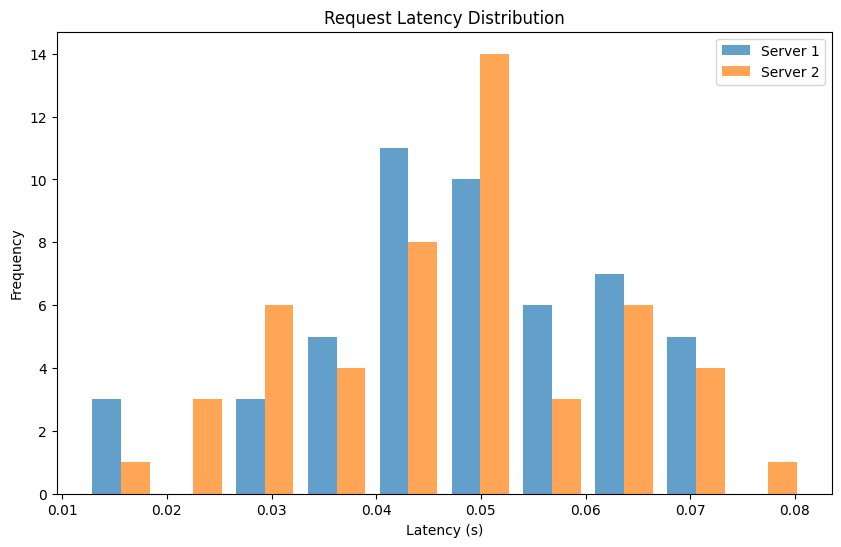

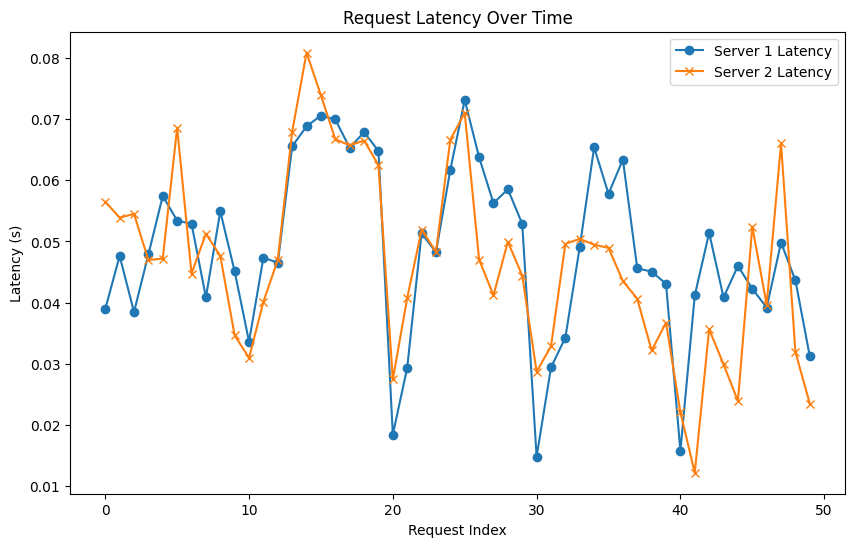

In [8]:
from flask import Flask, request, jsonify
import threading
import time
from itertools import cycle
from prometheus_client import Counter, Histogram, generate_latest, CollectorRegistry
import requests
import itertools
import matplotlib.pyplot as plt

# Clear the default registry to prevent duplicated metrics
REGISTRY = CollectorRegistry()

# Prometheus Metrics
REQUEST_COUNT = Counter("http_requests_total", "Total HTTP Requests", ["server"], registry=REGISTRY)
REQUEST_LATENCY = Histogram("http_request_latency_seconds", "Request Latency", ["server"], registry=REGISTRY)

# Initialize Flask apps
app1 = Flask("Server 1")
app2 = Flask("Server 2")

# Simulated workers
workers = ["Worker1", "Worker2", "Worker3"]
worker_iterator = cycle(workers)

# Define server endpoints with logging
@app1.route('/process', methods=['POST'])
def process_server1():
    start_time = time.time()
    data = request.get_json()
    worker = next(worker_iterator)
    REQUEST_COUNT.labels(server="Server 1").inc()
    REQUEST_LATENCY.labels(server="Server 1").observe(time.time() - start_time)
    return jsonify({"server": "Server 1", "worker": worker, "message": data['message']}), 200

@app2.route('/process', methods=['POST'])
def process_server2():
    start_time = time.time()
    data = request.get_json()
    worker = next(worker_iterator)
    REQUEST_COUNT.labels(server="Server 2").inc()
    REQUEST_LATENCY.labels(server="Server 2").observe(time.time() - start_time)
    return jsonify({"server": "Server 2", "worker": worker, "message": data['message']}), 200

# Start servers on separate threads
def start_server1():
    app1.run(port=5001)

def start_server2():
    app2.run(port=5002)

threading.Thread(target=start_server1).start()
threading.Thread(target=start_server2).start()


# Client Code (Simulated Requests and Metrics Collection)
servers = ["http://127.0.0.1:5001/process", "http://127.0.0.1:5002/process"]
server_iterator = itertools.cycle(servers)
server_logs = {"Server 1": [], "Server 2": []}

def send_request(message, request_id):
    server = next(server_iterator)
    try:
        start_time = time.time()
        response = requests.post(server, json={"message": message})
        elapsed_time = time.time() - start_time
        server_logs[response.json()["server"]].append(elapsed_time)
        print(f"Request {request_id}: {response.json()} | Time: {elapsed_time:.2f}s")
    except Exception as e:
        print(f"Request {request_id} failed: {e}")

# Simulate 1000 requests
def simulate_requests(total_requests, concurrency):
    threads = []
    for i in range(total_requests):
        t = threading.Thread(target=send_request, args=(f"Message {i+1}", i+1))
        threads.append(t)
        t.start()

        if (i + 1) % concurrency == 0:
            time.sleep(1)

    for t in threads:
        t.join()

simulate_requests(total_requests=100, concurrency=20)

# Plot server metrics
def plot_metrics():
    server1_times = server_logs["Server 1"]
    server2_times = server_logs["Server 2"]

    plt.figure(figsize=(10, 6))
    plt.hist([server1_times, server2_times], bins=10, label=["Server 1", "Server 2"], alpha=0.7)
    plt.title("Request Latency Distribution")
    plt.xlabel("Latency (s)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(server1_times)), server1_times, label="Server 1 Latency", marker='o')
    plt.plot(range(len(server2_times)), server2_times, label="Server 2 Latency", marker='x')
    plt.title("Request Latency Over Time")
    plt.xlabel("Request Index")
    plt.ylabel("Latency (s)")
    plt.legend()
    plt.show()

plot_metrics()


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:13] "POST /process HTTP/1.1" 200 -


Request 1: {'message': 'Message 1', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 2: {'message': 'Message 2', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 3: {'message': 'Message 3', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 4: {'message': 'Message 4', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 5: {'message': 'Message 5', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 7: {'message': 'Message 7', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 6: {'message': 'Message 6', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 8: {'message': 'Message 8', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 9: {'message': 'Message 9', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 10: {'message': 'Message 10', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:14] "POST /process HTTP/1.1" 200 -


Request 11: {'message': 'Message 11', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 14: {'message': 'Message 14', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 12: {'message': 'Message 12', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 13: {'message': 'Message 13', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 16: {'message': 'Message 16', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 15: {'message': 'Message 15', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 17: {'message': 'Message 17', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 19: {'message': 'Message 19', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 18: {'message': 'Message 18', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 20: {'message': 'Message 20', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:15] "POST /process HTTP/1.1" 200 -


Request 22: {'message': 'Message 22', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 23: {'message': 'Message 23', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 21: {'message': 'Message 21', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 25: {'message': 'Message 25', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 24: {'message': 'Message 24', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 26: {'message': 'Message 26', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 28: {'message': 'Message 28', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 27: {'message': 'Message 27', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 29: {'message': 'Message 29', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 30: {'message': 'Message 30', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:16] "POST /process HTTP/1.1" 200 -


Request 31: {'message': 'Message 31', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 32: {'message': 'Message 32', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 34: {'message': 'Message 34', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 33: {'message': 'Message 33', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 35: {'message': 'Message 35', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 36: {'message': 'Message 36', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 37: {'message': 'Message 37', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 38: {'message': 'Message 38', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 39: {'message': 'Message 39', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 40: {'message': 'Message 40', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:17] "POST /process HTTP/1.1" 200 -


Request 42: {'message': 'Message 42', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 41: {'message': 'Message 41', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 43: {'message': 'Message 43', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 44: {'message': 'Message 44', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 45: {'message': 'Message 45', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 46: {'message': 'Message 46', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 47: {'message': 'Message 47', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 48: {'message': 'Message 48', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 49: {'message': 'Message 49', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 50: {'message': 'Message 50', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:18] "POST /process HTTP/1.1" 200 -


Request 51: {'message': 'Message 51', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 52: {'message': 'Message 52', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 53: {'message': 'Message 53', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 54: {'message': 'Message 54', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 55: {'message': 'Message 55', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 56: {'message': 'Message 56', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 58: {'message': 'Message 58', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 60: {'message': 'Message 60', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 59: {'message': 'Message 59', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 57: {'message': 'Message 57', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.06s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:19] "POST /process HTTP/1.1" 200 -


Request 61: {'message': 'Message 61', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 62: {'message': 'Message 62', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 63: {'message': 'Message 63', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 64: {'message': 'Message 64', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 65: {'message': 'Message 65', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 66: {'message': 'Message 66', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 68: {'message': 'Message 68', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 67: {'message': 'Message 67', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 69: {'message': 'Message 69', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 70: {'message': 'Message 70', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:20] "POST /process HTTP/1.1" 200 -


Request 72: {'message': 'Message 72', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.01s
Request 71: {'message': 'Message 71', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 73: {'message': 'Message 73', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 74: {'message': 'Message 74', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 76: {'message': 'Message 76', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 75: {'message': 'Message 75', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 78: {'message': 'Message 78', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 77: {'message': 'Message 77', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 80: {'message': 'Message 80', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 79: {'message': 'Message 79', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:21] "POST /process HTTP/1.1" 200 -


Request 82: {'message': 'Message 82', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 81: {'message': 'Message 81', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 84: {'message': 'Message 84', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 83: {'message': 'Message 83', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 86: {'message': 'Message 86', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 85: {'message': 'Message 85', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 87: {'message': 'Message 87', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 88: {'message': 'Message 88', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 89: {'message': 'Message 89', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 90: {'message': 'Message 90', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:22] "POST /process HTTP/1.1" 200 -


Request 92: {'message': 'Message 92', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 91: {'message': 'Message 91', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 93: {'message': 'Message 93', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 94: {'message': 'Message 94', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 95: {'message': 'Message 95', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 96: {'message': 'Message 96', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 97: {'message': 'Message 97', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 99: {'message': 'Message 99', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 98: {'message': 'Message 98', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 100: {'message': 'Message 100', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:23] "POST /process HTTP/1.1" 200 -


Request 101: {'message': 'Message 101', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 102: {'message': 'Message 102', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 103: {'message': 'Message 103', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 104: {'message': 'Message 104', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 105: {'message': 'Message 105', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 107: {'message': 'Message 107', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 106: {'message': 'Message 106', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 109: {'message': 'Message 109', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 110: {'message': 'Message 110', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 108: {'message': 'Message 108', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:24] "POST /process HTTP/1.1" 200 -


Request 111: {'message': 'Message 111', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 112: {'message': 'Message 112', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 114: {'message': 'Message 114', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 113: {'message': 'Message 113', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 115: {'message': 'Message 115', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 116: {'message': 'Message 116', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 118: {'message': 'Message 118', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 117: {'message': 'Message 117', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 119: {'message': 'Message 119', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 120: {'message': 'Message 120', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:25] "POST /process HTTP/1.1" 200 -


Request 121: {'message': 'Message 121', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 122: {'message': 'Message 122', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 123: {'message': 'Message 123', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 124: {'message': 'Message 124', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 125: {'message': 'Message 125', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 126: {'message': 'Message 126', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 127: {'message': 'Message 127', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 129: {'message': 'Message 129', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 128: {'message': 'Message 128', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 130: {'message': 'Message 130', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:26] "POST /process HTTP/1.1" 200 -


Request 131: {'message': 'Message 131', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 133: {'message': 'Message 133', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 132: {'message': 'Message 132', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 134: {'message': 'Message 134', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 135: {'message': 'Message 135', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 136: {'message': 'Message 136', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 138: {'message': 'Message 138', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 139: {'message': 'Message 139', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 137: {'message': 'Message 137', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 140: {'message': 'Message 140', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:28] "POST /process HTTP/1.1" 200 -


Request 141: {'message': 'Message 141', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 142: {'message': 'Message 142', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 143: {'message': 'Message 143', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 144: {'message': 'Message 144', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 145: {'message': 'Message 145', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 147: {'message': 'Message 147', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 146: {'message': 'Message 146', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 148: {'message': 'Message 148', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 149: {'message': 'Message 149', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 150: {'message': 'Message 150', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:29] "POST /process HTTP/1.1" 200 -


Request 151: {'message': 'Message 151', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 152: {'message': 'Message 152', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 155: {'message': 'Message 155', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 153: {'message': 'Message 153', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 154: {'message': 'Message 154', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 156: {'message': 'Message 156', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 157: {'message': 'Message 157', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 158: {'message': 'Message 158', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 160: {'message': 'Message 160', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 159: {'message': 'Message 159', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:30] "POST /process HTTP/1.1" 200 -


Request 162: {'message': 'Message 162', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 161: {'message': 'Message 161', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 163: {'message': 'Message 163', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 164: {'message': 'Message 164', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 165: {'message': 'Message 165', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 167: {'message': 'Message 167', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 166: {'message': 'Message 166', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 168: {'message': 'Message 168', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.06s
Request 169: {'message': 'Message 169', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.06s
Request 170: {'message': 'Message 170', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:31] "POST /process HTTP/1.1" 200 -


Request 171: {'message': 'Message 171', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 172: {'message': 'Message 172', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 173: {'message': 'Message 173', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 174: {'message': 'Message 174', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 175: {'message': 'Message 175', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 176: {'message': 'Message 176', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 180: {'message': 'Message 180', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 179: {'message': 'Message 179', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 178: {'message': 'Message 178', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 177: {'message': 'Message 177', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:32] "POST /process HTTP/1.1" 200 -


Request 181: {'message': 'Message 181', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 182: {'message': 'Message 182', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 183: {'message': 'Message 183', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 185: {'message': 'Message 185', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 184: {'message': 'Message 184', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 187: {'message': 'Message 187', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 186: {'message': 'Message 186', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 188: {'message': 'Message 188', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 189: {'message': 'Message 189', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 190: {'message': 'Message 190', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:33] "POST /process HTTP/1.1" 200 -


Request 191: {'message': 'Message 191', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 192: {'message': 'Message 192', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 193: {'message': 'Message 193', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 196: {'message': 'Message 196', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 197: {'message': 'Message 197', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 195: {'message': 'Message 195', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 194: {'message': 'Message 194', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.06s
Request 198: {'message': 'Message 198', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 199: {'message': 'Message 199', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 200: {'message': 'Message 200', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:34] "POST /process HTTP/1.1" 200 -


Request 202: {'message': 'Message 202', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 201: {'message': 'Message 201', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 204: {'message': 'Message 204', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 203: {'message': 'Message 203', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 205: {'message': 'Message 205', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 207: {'message': 'Message 207', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 206: {'message': 'Message 206', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 208: {'message': 'Message 208', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 209: {'message': 'Message 209', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 210: {'message': 'Message 210', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:35] "POST /process HTTP/1.1" 200 -


Request 211: {'message': 'Message 211', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 213: {'message': 'Message 213', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 212: {'message': 'Message 212', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 214: {'message': 'Message 214', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 215: {'message': 'Message 215', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 216: {'message': 'Message 216', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 218: {'message': 'Message 218', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 217: {'message': 'Message 217', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 220: {'message': 'Message 220', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 219: {'message': 'Message 219', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:36] "POST /process HTTP/1.1" 200 -


Request 221: {'message': 'Message 221', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 222: {'message': 'Message 222', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 223: {'message': 'Message 223', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 224: {'message': 'Message 224', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 225: {'message': 'Message 225', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 226: {'message': 'Message 226', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 227: {'message': 'Message 227', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 228: {'message': 'Message 228', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 229: {'message': 'Message 229', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 230: {'message': 'Message 230', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:37] "POST /process HTTP/1.1" 200 -


Request 231: {'message': 'Message 231', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 232: {'message': 'Message 232', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 234: {'message': 'Message 234', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 233: {'message': 'Message 233', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 236: {'message': 'Message 236', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 237: {'message': 'Message 237', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 235: {'message': 'Message 235', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 238: {'message': 'Message 238', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 240: {'message': 'Message 240', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 239: {'message': 'Message 239', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:38] "POST /process HTTP/1.1" 200 -


Request 241: {'message': 'Message 241', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 243: {'message': 'Message 243', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 242: {'message': 'Message 242', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 245: {'message': 'Message 245', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 244: {'message': 'Message 244', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 246: {'message': 'Message 246', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 248: {'message': 'Message 248', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 247: {'message': 'Message 247', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 249: {'message': 'Message 249', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 250: {'message': 'Message 250', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:39] "POST /process HTTP/1.1" 200 -


Request 252: {'message': 'Message 252', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.01s
Request 251: {'message': 'Message 251', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 253: {'message': 'Message 253', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 254: {'message': 'Message 254', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 255: {'message': 'Message 255', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 256: {'message': 'Message 256', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 257: {'message': 'Message 257', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 259: {'message': 'Message 259', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 258: {'message': 'Message 258', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 260: {'message': 'Message 260', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:40] "POST /process HTTP/1.1" 200 -


Request 261: {'message': 'Message 261', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 263: {'message': 'Message 263', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 262: {'message': 'Message 262', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 264: {'message': 'Message 264', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 265: {'message': 'Message 265', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 267: {'message': 'Message 267', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 266: {'message': 'Message 266', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 268: {'message': 'Message 268', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 269: {'message': 'Message 269', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 270: {'message': 'Message 270', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:41] "POST /process HTTP/1.1" 200 -


Request 271: {'message': 'Message 271', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 272: {'message': 'Message 272', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 273: {'message': 'Message 273', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 274: {'message': 'Message 274', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 276: {'message': 'Message 276', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 275: {'message': 'Message 275', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 278: {'message': 'Message 278', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 277: {'message': 'Message 277', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 280: {'message': 'Message 280', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 279: {'message': 'Message 279', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:42] "POST /process HTTP/1.1" 200 -


Request 281: {'message': 'Message 281', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 284: {'message': 'Message 284', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.01s
Request 283: {'message': 'Message 283', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 282: {'message': 'Message 282', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 285: {'message': 'Message 285', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 286: {'message': 'Message 286', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 287: {'message': 'Message 287', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 288: {'message': 'Message 288', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 289: {'message': 'Message 289', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 290: {'message': 'Message 290', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:43] "POST /process HTTP/1.1" 200 -


Request 291: {'message': 'Message 291', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 294: {'message': 'Message 294', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 292: {'message': 'Message 292', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 293: {'message': 'Message 293', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 295: {'message': 'Message 295', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 296: {'message': 'Message 296', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 297: {'message': 'Message 297', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 298: {'message': 'Message 298', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 299: {'message': 'Message 299', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 300: {'message': 'Message 300', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:44] "POST /process HTTP/1.1" 200 -


Request 301: {'message': 'Message 301', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 302: {'message': 'Message 302', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 303: {'message': 'Message 303', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 304: {'message': 'Message 304', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 305: {'message': 'Message 305', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 308: {'message': 'Message 308', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 306: {'message': 'Message 306', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.06s
Request 307: {'message': 'Message 307', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 309: {'message': 'Message 309', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 310: {'message': 'Message 310', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:46] "POST /process HTTP/1.1" 200 -


Request 311: {'message': 'Message 311', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 313: {'message': 'Message 313', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 312: {'message': 'Message 312', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 315: {'message': 'Message 315', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 314: {'message': 'Message 314', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 316: {'message': 'Message 316', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 318: {'message': 'Message 318', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 317: {'message': 'Message 317', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 319: {'message': 'Message 319', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 320: {'message': 'Message 320', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:47] "POST /process HTTP/1.1" 200 -


Request 322: {'message': 'Message 322', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 321: {'message': 'Message 321', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 323: {'message': 'Message 323', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 324: {'message': 'Message 324', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 325: {'message': 'Message 325', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 326: {'message': 'Message 326', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 327: {'message': 'Message 327', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 329: {'message': 'Message 329', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 328: {'message': 'Message 328', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 330: {'message': 'Message 330', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:48] "POST /process HTTP/1.1" 200 -


Request 331: {'message': 'Message 331', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 332: {'message': 'Message 332', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 333: {'message': 'Message 333', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 335: {'message': 'Message 335', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 336: {'message': 'Message 336', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 334: {'message': 'Message 334', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.06s
Request 337: {'message': 'Message 337', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 338: {'message': 'Message 338', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 339: {'message': 'Message 339', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 340: {'message': 'Message 340', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:49] "POST /process HTTP/1.1" 200 -


Request 341: {'message': 'Message 341', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 343: {'message': 'Message 343', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 342: {'message': 'Message 342', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 344: {'message': 'Message 344', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 345: {'message': 'Message 345', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 347: {'message': 'Message 347', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 346: {'message': 'Message 346', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 348: {'message': 'Message 348', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 349: {'message': 'Message 349', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 350: {'message': 'Message 350', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:50] "POST /process HTTP/1.1" 200 -


Request 351: {'message': 'Message 351', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 352: {'message': 'Message 352', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 353: {'message': 'Message 353', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 354: {'message': 'Message 354', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 355: {'message': 'Message 355', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 356: {'message': 'Message 356', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 357: {'message': 'Message 357', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 358: {'message': 'Message 358', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 359: {'message': 'Message 359', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 360: {'message': 'Message 360', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:51] "POST /process HTTP/1.1" 200 -


Request 361: {'message': 'Message 361', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 363: {'message': 'Message 363', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 365: {'message': 'Message 365', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 367: {'message': 'Message 367', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 364: {'message': 'Message 364', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 362: {'message': 'Message 362', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 366: {'message': 'Message 366', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 368: {'message': 'Message 368', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 369: {'message': 'Message 369', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 370: {'message': 'Message 370', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:52] "POST /process HTTP/1.1" 200 -


Request 371: {'message': 'Message 371', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 372: {'message': 'Message 372', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 373: {'message': 'Message 373', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 374: {'message': 'Message 374', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 376: {'message': 'Message 376', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 375: {'message': 'Message 375', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 377: {'message': 'Message 377', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 378: {'message': 'Message 378', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 379: {'message': 'Message 379', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 380: {'message': 'Message 380', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:53] "POST /process HTTP/1.1" 200 -


Request 381: {'message': 'Message 381', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 382: {'message': 'Message 382', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 383: {'message': 'Message 383', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 384: {'message': 'Message 384', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04sRequest 385: {'message': 'Message 385', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s

Request 386: {'message': 'Message 386', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 387: {'message': 'Message 387', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 388: {'message': 'Message 388', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 389: {'message': 'Message 389', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 390: {'message': 'Message 390', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:54] "POST /process HTTP/1.1" 200 -


Request 391: {'message': 'Message 391', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 392: {'message': 'Message 392', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 393: {'message': 'Message 393', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 394: {'message': 'Message 394', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 396: {'message': 'Message 396', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 397: {'message': 'Message 397', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 395: {'message': 'Message 395', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 398: {'message': 'Message 398', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 399: {'message': 'Message 399', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 400: {'message': 'Message 400', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:55] "POST /process HTTP/1.1" 200 -


Request 403: {'message': 'Message 403', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 402: {'message': 'Message 402', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 401: {'message': 'Message 401', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 404: {'message': 'Message 404', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 405: {'message': 'Message 405', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 406: {'message': 'Message 406', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 407: {'message': 'Message 407', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 408: {'message': 'Message 408', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 410: {'message': 'Message 410', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 409: {'message': 'Message 409', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:56] "POST /process HTTP/1.1" 200 -


Request 411: {'message': 'Message 411', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01sRequest 412: {'message': 'Message 412', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s

Request 414: {'message': 'Message 414', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 413: {'message': 'Message 413', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 415: {'message': 'Message 415', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 416: {'message': 'Message 416', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 419: {'message': 'Message 419', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 417: {'message': 'Message 417', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 418: {'message': 'Message 418', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 420: {'message': 'Message 420', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:57] "POST /process HTTP/1.1" 200 -


Request 421: {'message': 'Message 421', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 422: {'message': 'Message 422', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 423: {'message': 'Message 423', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 424: {'message': 'Message 424', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 425: {'message': 'Message 425', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 426: {'message': 'Message 426', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 430: {'message': 'Message 430', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 427: {'message': 'Message 427', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 428: {'message': 'Message 428', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 429: {'message': 'Message 429', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:58] "POST /process HTTP/1.1" 200 -


Request 432: {'message': 'Message 432', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 433: {'message': 'Message 433', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 431: {'message': 'Message 431', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 434: {'message': 'Message 434', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 437: {'message': 'Message 437', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 435: {'message': 'Message 435', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 436: {'message': 'Message 436', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 440: {'message': 'Message 440', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 438: {'message': 'Message 438', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 439: {'message': 'Message 439', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:22:59] "POST /process HTTP/1.1" 200 -


Request 441: {'message': 'Message 441', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 443: {'message': 'Message 443', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 442: {'message': 'Message 442', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 445: {'message': 'Message 445', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 444: {'message': 'Message 444', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 446: {'message': 'Message 446', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 447: {'message': 'Message 447', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 448: {'message': 'Message 448', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 449: {'message': 'Message 449', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 450: {'message': 'Message 450', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:00] "POST /process HTTP/1.1" 200 -


Request 451: {'message': 'Message 451', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 453: {'message': 'Message 453', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 454: {'message': 'Message 454', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 455: {'message': 'Message 455', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 452: {'message': 'Message 452', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 456: {'message': 'Message 456', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 457: {'message': 'Message 457', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 458: {'message': 'Message 458', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 459: {'message': 'Message 459', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 460: {'message': 'Message 460', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:01] "POST /process HTTP/1.1" 200 -


Request 461: {'message': 'Message 461', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 462: {'message': 'Message 462', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 463: {'message': 'Message 463', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 464: {'message': 'Message 464', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 465: {'message': 'Message 465', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 466: {'message': 'Message 466', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 470: {'message': 'Message 470', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 467: {'message': 'Message 467', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 468: {'message': 'Message 468', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 469: {'message': 'Message 469', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:02] "POST /process HTTP/1.1" 200 -


Request 473: {'message': 'Message 473', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 471: {'message': 'Message 471', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 472: {'message': 'Message 472', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 475: {'message': 'Message 475', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 474: {'message': 'Message 474', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 476: {'message': 'Message 476', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 477: {'message': 'Message 477', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 478: {'message': 'Message 478', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 479: {'message': 'Message 479', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 480: {'message': 'Message 480', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:03] "POST /process HTTP/1.1" 200 -


Request 482: {'message': 'Message 482', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.01s
Request 481: {'message': 'Message 481', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 483: {'message': 'Message 483', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 484: {'message': 'Message 484', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 486: {'message': 'Message 486', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 485: {'message': 'Message 485', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 488: {'message': 'Message 488', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 487: {'message': 'Message 487', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 489: {'message': 'Message 489', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 490: {'message': 'Message 490', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:04] "POST /process HTTP/1.1" 200 -


Request 491: {'message': 'Message 491', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 492: {'message': 'Message 492', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 494: {'message': 'Message 494', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 498: {'message': 'Message 498', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 496: {'message': 'Message 496', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 495: {'message': 'Message 495', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 497: {'message': 'Message 497', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 499: {'message': 'Message 499', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 493: {'message': 'Message 493', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.06s
Request 500: {'message': 'Message 500', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:05] "POST /process HTTP/1.1" 200 -


Request 501: {'message': 'Message 501', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 502: {'message': 'Message 502', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 503: {'message': 'Message 503', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 504: {'message': 'Message 504', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 505: {'message': 'Message 505', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 507: {'message': 'Message 507', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 506: {'message': 'Message 506', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 510: {'message': 'Message 510', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 509: {'message': 'Message 509', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 508: {'message': 'Message 508', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:06] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:06] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:07] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:07] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:07] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:07] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:07] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:07] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:07] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:07] "POST /process HTTP/1.1" 200 -


Request 511: {'message': 'Message 511', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 512: {'message': 'Message 512', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.01s
Request 513: {'message': 'Message 513', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 514: {'message': 'Message 514', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 516: {'message': 'Message 516', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 517: {'message': 'Message 517', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 515: {'message': 'Message 515', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 518: {'message': 'Message 518', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 519: {'message': 'Message 519', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 520: {'message': 'Message 520', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:08] "POST /process HTTP/1.1" 200 -


Request 521: {'message': 'Message 521', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 522: {'message': 'Message 522', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 523: {'message': 'Message 523', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 524: {'message': 'Message 524', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 525: {'message': 'Message 525', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 526: {'message': 'Message 526', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 527: {'message': 'Message 527', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 528: {'message': 'Message 528', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 529: {'message': 'Message 529', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 530: {'message': 'Message 530', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:09] "POST /process HTTP/1.1" 200 -


Request 531: {'message': 'Message 531', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 533: {'message': 'Message 533', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 532: {'message': 'Message 532', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 534: {'message': 'Message 534', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 535: {'message': 'Message 535', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 536: {'message': 'Message 536', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 537: {'message': 'Message 537', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 538: {'message': 'Message 538', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 539: {'message': 'Message 539', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 540: {'message': 'Message 540', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:10] "POST /process HTTP/1.1" 200 -


Request 541: {'message': 'Message 541', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 542: {'message': 'Message 542', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 543: {'message': 'Message 543', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 544: {'message': 'Message 544', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 545: {'message': 'Message 545', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 546: {'message': 'Message 546', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 547: {'message': 'Message 547', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 548: {'message': 'Message 548', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 550: {'message': 'Message 550', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 549: {'message': 'Message 549', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:11] "POST /process HTTP/1.1" 200 -


Request 551: {'message': 'Message 551', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 553: {'message': 'Message 553', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 552: {'message': 'Message 552', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 554: {'message': 'Message 554', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 555: {'message': 'Message 555', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 556: {'message': 'Message 556', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 557: {'message': 'Message 557', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 558: {'message': 'Message 558', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 560: {'message': 'Message 560', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 559: {'message': 'Message 559', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:12] "POST /process HTTP/1.1" 200 -


Request 561: {'message': 'Message 561', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.12s
Request 562: {'message': 'Message 562', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.12s
Request 563: {'message': 'Message 563', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.12s
Request 564: {'message': 'Message 564', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 567: {'message': 'Message 567', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02sRequest 565: {'message': 'Message 565', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 566: {'message': 'Message 566', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s

Request 570: {'message': 'Message 570', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 568: {'message': 'Message 568', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 569: {'message': 'Message 569', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:13] "POST /process HTTP/1.1" 200 -


Request 572: {'message': 'Message 572', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 571: {'message': 'Message 571', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 573: {'message': 'Message 573', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 574: {'message': 'Message 574', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 578: {'message': 'Message 578', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 575: {'message': 'Message 575', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 576: {'message': 'Message 576', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 579: {'message': 'Message 579', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 577: {'message': 'Message 577', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 580: {'message': 'Message 580', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:14] "POST /process HTTP/1.1" 200 -


Request 581: {'message': 'Message 581', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 582: {'message': 'Message 582', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 583: {'message': 'Message 583', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 584: {'message': 'Message 584', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 585: {'message': 'Message 585', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 586: {'message': 'Message 586', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 588: {'message': 'Message 588', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 587: {'message': 'Message 587', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 589: {'message': 'Message 589', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 590: {'message': 'Message 590', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:15] "POST /process HTTP/1.1" 200 -


Request 591: {'message': 'Message 591', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 593: {'message': 'Message 593', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 592: {'message': 'Message 592', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 594: {'message': 'Message 594', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 596: {'message': 'Message 596', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 595: {'message': 'Message 595', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 598: {'message': 'Message 598', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 597: {'message': 'Message 597', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 599: {'message': 'Message 599', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 600: {'message': 'Message 600', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:16] "POST /process HTTP/1.1" 200 -


Request 601: {'message': 'Message 601', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 604: {'message': 'Message 604', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 602: {'message': 'Message 602', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 606: {'message': 'Message 606', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 603: {'message': 'Message 603', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 608: {'message': 'Message 608', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 605: {'message': 'Message 605', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.06s
Request 610: {'message': 'Message 610', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 607: {'message': 'Message 607', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.07s
Request 609: {'message': 'Message 609', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:17] "POST /process HTTP/1.1" 200 -


Request 612: {'message': 'Message 612', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.01s
Request 614: {'message': 'Message 614', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 611: {'message': 'Message 611', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 616: {'message': 'Message 616', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 613: {'message': 'Message 613', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 618: {'message': 'Message 618', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 615: {'message': 'Message 615', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 617: {'message': 'Message 617', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 619: {'message': 'Message 619', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 620: {'message': 'Message 620', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:18] "POST /process HTTP/1.1" 200 -


Request 621: {'message': 'Message 621', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 623: {'message': 'Message 623', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 627: {'message': 'Message 627', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 622: {'message': 'Message 622', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 625: {'message': 'Message 625', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 624: {'message': 'Message 624', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 629: {'message': 'Message 629', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 626: {'message': 'Message 626', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.06s
Request 630: {'message': 'Message 630', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 628: {'message': 'Message 628', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.07s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:19] "POST /process HTTP/1.1" 200 -


Request 631: {'message': 'Message 631', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 632: {'message': 'Message 632', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 633: {'message': 'Message 633', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 634: {'message': 'Message 634', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 635: {'message': 'Message 635', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 636: {'message': 'Message 636', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 638: {'message': 'Message 638', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 637: {'message': 'Message 637', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 640: {'message': 'Message 640', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 639: {'message': 'Message 639', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:20] "POST /process HTTP/1.1" 200 -


Request 641: {'message': 'Message 641', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 644: {'message': 'Message 644', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 642: {'message': 'Message 642', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 645: {'message': 'Message 645', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 643: {'message': 'Message 643', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 646: {'message': 'Message 646', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 647: {'message': 'Message 647', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 648: {'message': 'Message 648', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 649: {'message': 'Message 649', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 650: {'message': 'Message 650', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:21] "POST /process HTTP/1.1" 200 -


Request 651: {'message': 'Message 651', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 652: {'message': 'Message 652', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 653: {'message': 'Message 653', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 654: {'message': 'Message 654', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 655: {'message': 'Message 655', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 657: {'message': 'Message 657', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 656: {'message': 'Message 656', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 659: {'message': 'Message 659', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 658: {'message': 'Message 658', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 660: {'message': 'Message 660', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:22] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:23] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:23] "POST /process HTTP/1.1" 200 -


Request 661: {'message': 'Message 661', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 662: {'message': 'Message 662', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 663: {'message': 'Message 663', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 664: {'message': 'Message 664', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 666: {'message': 'Message 666', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 665: {'message': 'Message 665', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 667: {'message': 'Message 667', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 668: {'message': 'Message 668', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 669: {'message': 'Message 669', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 670: {'message': 'Message 670', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:24] "POST /process HTTP/1.1" 200 -


Request 671: {'message': 'Message 671', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 673: {'message': 'Message 673', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 672: {'message': 'Message 672', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 675: {'message': 'Message 675', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 676: {'message': 'Message 676', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 674: {'message': 'Message 674', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.06s
Request 677: {'message': 'Message 677', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 678: {'message': 'Message 678', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 679: {'message': 'Message 679', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 680: {'message': 'Message 680', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:25] "POST /process HTTP/1.1" 200 -


Request 682: {'message': 'Message 682', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 683: {'message': 'Message 683', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 681: {'message': 'Message 681', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 684: {'message': 'Message 684', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 685: {'message': 'Message 685', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 687: {'message': 'Message 687', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 686: {'message': 'Message 686', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 688: {'message': 'Message 688', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04sRequest 689: {'message': 'Message 689', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s

Request 690: {'message': 'Message 690', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:26] "POST /process HTTP/1.1" 200 -


Request 691: {'message': 'Message 691', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 693: {'message': 'Message 693', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 692: {'message': 'Message 692', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 694: {'message': 'Message 694', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 695: {'message': 'Message 695', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 696: {'message': 'Message 696', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 700: {'message': 'Message 700', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 698: {'message': 'Message 698', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 697: {'message': 'Message 697', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.06s
Request 699: {'message': 'Message 699', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:27] "POST /process HTTP/1.1" 200 -


Request 701: {'message': 'Message 701', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 702: {'message': 'Message 702', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 703: {'message': 'Message 703', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 704: {'message': 'Message 704', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 705: {'message': 'Message 705', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 709: {'message': 'Message 709', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 707: {'message': 'Message 707', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 706: {'message': 'Message 706', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 710: {'message': 'Message 710', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 708: {'message': 'Message 708', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:28] "POST /process HTTP/1.1" 200 -


Request 712: {'message': 'Message 712', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 711: {'message': 'Message 711', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 713: {'message': 'Message 713', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 714: {'message': 'Message 714', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 716: {'message': 'Message 716', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 715: {'message': 'Message 715', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.06s
Request 718: {'message': 'Message 718', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 720: {'message': 'Message 720', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 719: {'message': 'Message 719', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 717: {'message': 'Message 717', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.06s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:29] "POST /process HTTP/1.1" 200 -


Request 722: {'message': 'Message 722', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 721: {'message': 'Message 721', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 723: {'message': 'Message 723', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 724: {'message': 'Message 724', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 726: {'message': 'Message 726', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 728: {'message': 'Message 728', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 725: {'message': 'Message 725', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 730: {'message': 'Message 730', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 727: {'message': 'Message 727', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.06s
Request 729: {'message': 'Message 729', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.06s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:30] "POST /process HTTP/1.1" 200 -


Request 731: {'message': 'Message 731', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02sRequest 732: {'message': 'Message 732', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s

Request 733: {'message': 'Message 733', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 734: {'message': 'Message 734', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 735: {'message': 'Message 735', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 736: {'message': 'Message 736', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 737: {'message': 'Message 737', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 738: {'message': 'Message 738', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 739: {'message': 'Message 739', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 740: {'message': 'Message 740', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:31] "POST /process HTTP/1.1" 200 -


Request 741: {'message': 'Message 741', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 742: {'message': 'Message 742', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 743: {'message': 'Message 743', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 744: {'message': 'Message 744', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 745: {'message': 'Message 745', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 746: {'message': 'Message 746', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 748: {'message': 'Message 748', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 747: {'message': 'Message 747', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.06s
Request 749: {'message': 'Message 749', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 750: {'message': 'Message 750', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:32] "POST /process HTTP/1.1" 200 -


Request 752: {'message': 'Message 752', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 753: {'message': 'Message 753', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 754: {'message': 'Message 754', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 751: {'message': 'Message 751', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 756: {'message': 'Message 756', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 755: {'message': 'Message 755', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 757: {'message': 'Message 757', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 758: {'message': 'Message 758', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 759: {'message': 'Message 759', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 760: {'message': 'Message 760', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:33] "POST /process HTTP/1.1" 200 -


Request 761: {'message': 'Message 761', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 762: {'message': 'Message 762', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 766: {'message': 'Message 766', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 767: {'message': 'Message 767', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 764: {'message': 'Message 764', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 765: {'message': 'Message 765', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 763: {'message': 'Message 763', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.06s
Request 768: {'message': 'Message 768', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 769: {'message': 'Message 769', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 770: {'message': 'Message 770', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:34] "POST /process HTTP/1.1" 200 -


Request 772: {'message': 'Message 772', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01sRequest 771: {'message': 'Message 771', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s

Request 773: {'message': 'Message 773', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 774: {'message': 'Message 774', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 775: {'message': 'Message 775', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 776: {'message': 'Message 776', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 777: {'message': 'Message 777', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 778: {'message': 'Message 778', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 779: {'message': 'Message 779', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 780: {'message': 'Message 780', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:35] "POST /process HTTP/1.1" 200 -


Request 781: {'message': 'Message 781', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 782: {'message': 'Message 782', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 783: {'message': 'Message 783', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 784: {'message': 'Message 784', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 785: {'message': 'Message 785', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 786: {'message': 'Message 786', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 787: {'message': 'Message 787', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 788: {'message': 'Message 788', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 790: {'message': 'Message 790', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 789: {'message': 'Message 789', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:36] "POST /process HTTP/1.1" 200 -


Request 791: {'message': 'Message 791', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 792: {'message': 'Message 792', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 793: {'message': 'Message 793', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 795: {'message': 'Message 795', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 794: {'message': 'Message 794', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.06s
Request 796: {'message': 'Message 796', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.06s
Request 797: {'message': 'Message 797', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.06s
Request 798: {'message': 'Message 798', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 799: {'message': 'Message 799', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 800: {'message': 'Message 800', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:37] "POST /process HTTP/1.1" 200 -


Request 801: {'message': 'Message 801', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 803: {'message': 'Message 803', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 802: {'message': 'Message 802', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 804: {'message': 'Message 804', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.06s
Request 806: {'message': 'Message 806', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 805: {'message': 'Message 805', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.06s
Request 807: {'message': 'Message 807', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 808: {'message': 'Message 808', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 809: {'message': 'Message 809', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 810: {'message': 'Message 810', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:38] "POST /process HTTP/1.1" 200 -


Request 812: {'message': 'Message 812', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 811: {'message': 'Message 811', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 814: {'message': 'Message 814', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 813: {'message': 'Message 813', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 815: {'message': 'Message 815', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 816: {'message': 'Message 816', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 818: {'message': 'Message 818', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 817: {'message': 'Message 817', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 820: {'message': 'Message 820', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 819: {'message': 'Message 819', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:39] "POST /process HTTP/1.1" 200 -


Request 821: {'message': 'Message 821', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 822: {'message': 'Message 822', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 823: {'message': 'Message 823', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 824: {'message': 'Message 824', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 825: {'message': 'Message 825', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 826: {'message': 'Message 826', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 827: {'message': 'Message 827', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 828: {'message': 'Message 828', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 829: {'message': 'Message 829', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 830: {'message': 'Message 830', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:40] "POST /process HTTP/1.1" 200 -


Request 832: {'message': 'Message 832', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 831: {'message': 'Message 831', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 833: {'message': 'Message 833', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 834: {'message': 'Message 834', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 836: {'message': 'Message 836', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.01s
Request 835: {'message': 'Message 835', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 838: {'message': 'Message 838', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 837: {'message': 'Message 837', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 839: {'message': 'Message 839', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 840: {'message': 'Message 840', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:41] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:42] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:42] "POST /process HTTP/1.1" 200 -


Request 841: {'message': 'Message 841', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 842: {'message': 'Message 842', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 843: {'message': 'Message 843', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 844: {'message': 'Message 844', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 845: {'message': 'Message 845', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 847: {'message': 'Message 847', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 846: {'message': 'Message 846', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 850: {'message': 'Message 850', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 849: {'message': 'Message 849', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.05s
Request 848: {'message': 'Message 848', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.06s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:43] "POST /process HTTP/1.1" 200 -


Request 852: {'message': 'Message 852', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 851: {'message': 'Message 851', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 853: {'message': 'Message 853', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 854: {'message': 'Message 854', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 855: {'message': 'Message 855', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 856: {'message': 'Message 856', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 858: {'message': 'Message 858', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 857: {'message': 'Message 857', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 859: {'message': 'Message 859', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 860: {'message': 'Message 860', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:44] "POST /process HTTP/1.1" 200 -


Request 861: {'message': 'Message 861', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 863: {'message': 'Message 863', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 862: {'message': 'Message 862', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 864: {'message': 'Message 864', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 866: {'message': 'Message 866', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 867: {'message': 'Message 867', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 869: {'message': 'Message 869', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 865: {'message': 'Message 865', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 868: {'message': 'Message 868', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 870: {'message': 'Message 870', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:45] "POST /process HTTP/1.1" 200 -


Request 871: {'message': 'Message 871', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 872: {'message': 'Message 872', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 874: {'message': 'Message 874', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 873: {'message': 'Message 873', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 875: {'message': 'Message 875', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 876: {'message': 'Message 876', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 878: {'message': 'Message 878', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 877: {'message': 'Message 877', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 880: {'message': 'Message 880', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 879: {'message': 'Message 879', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:46] "POST /process HTTP/1.1" 200 -


Request 881: {'message': 'Message 881', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 882: {'message': 'Message 882', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 883: {'message': 'Message 883', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 884: {'message': 'Message 884', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 885: {'message': 'Message 885', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 886: {'message': 'Message 886', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 887: {'message': 'Message 887', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 888: {'message': 'Message 888', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 889: {'message': 'Message 889', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 890: {'message': 'Message 890', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:47] "POST /process HTTP/1.1" 200 -


Request 891: {'message': 'Message 891', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 892: {'message': 'Message 892', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 894: {'message': 'Message 894', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 893: {'message': 'Message 893', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 895: {'message': 'Message 895', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 896: {'message': 'Message 896', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 897: {'message': 'Message 897', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 898: {'message': 'Message 898', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 899: {'message': 'Message 899', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 900: {'message': 'Message 900', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:48] "POST /process HTTP/1.1" 200 -


Request 901: {'message': 'Message 901', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 903: {'message': 'Message 903', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 902: {'message': 'Message 902', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 904: {'message': 'Message 904', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 906: {'message': 'Message 906', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 905: {'message': 'Message 905', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 908: {'message': 'Message 908', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 907: {'message': 'Message 907', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 910: {'message': 'Message 910', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.05s
Request 909: {'message': 'Message 909', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.06s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:49] "POST /process HTTP/1.1" 200 -


Request 911: {'message': 'Message 911', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 913: {'message': 'Message 913', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 915: {'message': 'Message 915', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 912: {'message': 'Message 912', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.05s
Request 914: {'message': 'Message 914', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 916: {'message': 'Message 916', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 917: {'message': 'Message 917', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 918: {'message': 'Message 918', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s
Request 919: {'message': 'Message 919', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 920: {'message': 'Message 920', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:50] "POST /process HTTP/1.1" 200 -


Request 921: {'message': 'Message 921', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 923: {'message': 'Message 923', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 925: {'message': 'Message 925', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 924: {'message': 'Message 924', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.05s
Request 922: {'message': 'Message 922', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.07s
Request 926: {'message': 'Message 926', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 927: {'message': 'Message 927', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.05s
Request 928: {'message': 'Message 928', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 930: {'message': 'Message 930', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 929: {'message': 'Message 929', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:51] "POST /process HTTP/1.1" 200 -


Request 931: {'message': 'Message 931', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 932: {'message': 'Message 932', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 933: {'message': 'Message 933', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 934: {'message': 'Message 934', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 935: {'message': 'Message 935', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 936: {'message': 'Message 936', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 937: {'message': 'Message 937', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.05s
Request 938: {'message': 'Message 938', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 939: {'message': 'Message 939', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 940: {'message': 'Message 940', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:52] "POST /process HTTP/1.1" 200 -


Request 941: {'message': 'Message 941', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 942: {'message': 'Message 942', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 943: {'message': 'Message 943', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 944: {'message': 'Message 944', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 946: {'message': 'Message 946', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.02s
Request 948: {'message': 'Message 948', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 945: {'message': 'Message 945', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s
Request 947: {'message': 'Message 947', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 950: {'message': 'Message 950', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 949: {'message': 'Message 949', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:53] "POST /process HTTP/1.1" 200 -


Request 951: {'message': 'Message 951', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.01s
Request 952: {'message': 'Message 952', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 954: {'message': 'Message 954', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 953: {'message': 'Message 953', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 955: {'message': 'Message 955', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 956: {'message': 'Message 956', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 957: {'message': 'Message 957', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 958: {'message': 'Message 958', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s
Request 959: {'message': 'Message 959', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 960: {'message': 'Message 960', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.01s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:54] "POST /process HTTP/1.1" 200 -


Request 961: {'message': 'Message 961', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.01s
Request 962: {'message': 'Message 962', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s
Request 964: {'message': 'Message 964', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 965: {'message': 'Message 965', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 963: {'message': 'Message 963', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.04s
Request 967: {'message': 'Message 967', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 966: {'message': 'Message 966', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 968: {'message': 'Message 968', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 969: {'message': 'Message 969', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 970: {'message': 'Message 970', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.03s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:55] "POST /process HTTP/1.1" 200 -


Request 973: {'message': 'Message 973', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.01s
Request 971: {'message': 'Message 971', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 972: {'message': 'Message 972', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 974: {'message': 'Message 974', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 975: {'message': 'Message 975', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s
Request 976: {'message': 'Message 976', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 977: {'message': 'Message 977', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 979: {'message': 'Message 979', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 978: {'message': 'Message 978', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 980: {'message': 'Message 980', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.02s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:56] "POST /process HTTP/1.1" 200 -


Request 981: {'message': 'Message 981', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.02s
Request 982: {'message': 'Message 982', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 983: {'message': 'Message 983', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.02s
Request 984: {'message': 'Message 984', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.03s
Request 986: {'message': 'Message 986', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.02s
Request 985: {'message': 'Message 985', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 987: {'message': 'Message 987', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 988: {'message': 'Message 988', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 990: {'message': 'Message 990', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 989: {'message': 'Message 989', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.04s


INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jan/2025 14:23:57] "POST /process HTTP/1.1" 200 -


Request 991: {'message': 'Message 991', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.02s
Request 992: {'message': 'Message 992', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.03s
Request 993: {'message': 'Message 993', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 995: {'message': 'Message 995', 'server': 'Server 1', 'worker': 'Worker2'} | Time: 0.03s
Request 994: {'message': 'Message 994', 'server': 'Server 2', 'worker': 'Worker3'} | Time: 0.04s
Request 997: {'message': 'Message 997', 'server': 'Server 1', 'worker': 'Worker1'} | Time: 0.03s
Request 996: {'message': 'Message 996', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s
Request 999: {'message': 'Message 999', 'server': 'Server 1', 'worker': 'Worker3'} | Time: 0.03s
Request 998: {'message': 'Message 998', 'server': 'Server 2', 'worker': 'Worker1'} | Time: 0.04s
Request 1000: {'message': 'Message 1000', 'server': 'Server 2', 'worker': 'Worker2'} | Time: 0.04s


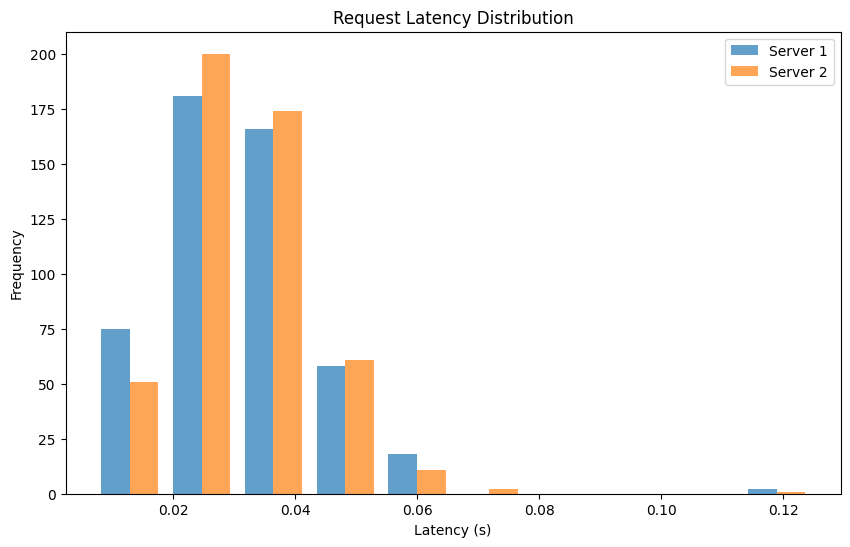

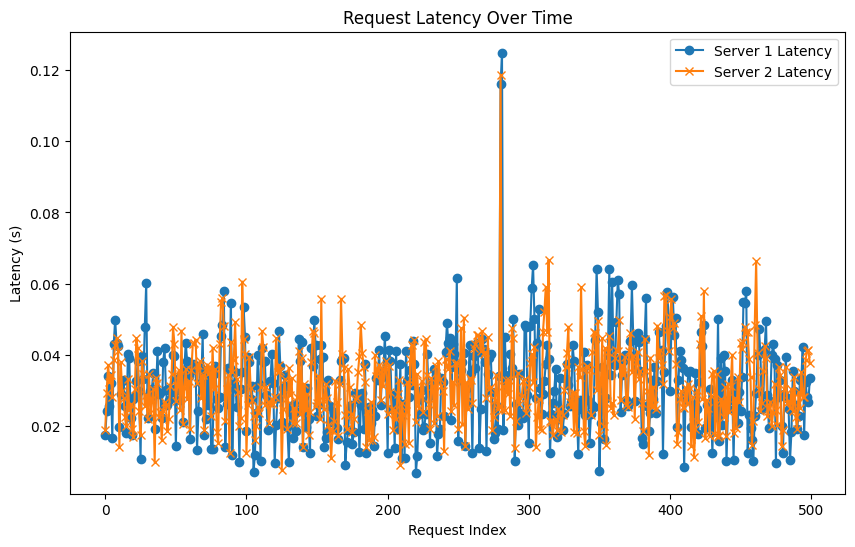

In [9]:
import requests
import itertools
import threading
import time
import matplotlib.pyplot as plt

# Servers to interact with
servers = ["http://127.0.0.1:5001/process", "http://127.0.0.1:5002/process"]
server_iterator = itertools.cycle(servers)
server_logs = {"Server 1": [], "Server 2": []}

def send_request(message, request_id):
    server = next(server_iterator)
    try:
        start_time = time.time()
        response = requests.post(server, json={"message": message})
        elapsed_time = time.time() - start_time
        server_logs[response.json()["server"]].append(elapsed_time)
        print(f"Request {request_id}: {response.json()} | Time: {elapsed_time:.2f}s")
    except requests.exceptions.RequestException as e:
        print(f"Request {request_id} failed: {e}")

# Simulate 1000 requests with concurrency to test rate limiting
def simulate_requests(total_requests, concurrency):
    threads = []
    for i in range(total_requests):
        t = threading.Thread(target=send_request, args=(f"Message {i+1}", i+1))
        threads.append(t)
        t.start()

        if (i + 1) % concurrency == 0:
            time.sleep(1)

    for t in threads:
        t.join()

simulate_requests(total_requests=1000, concurrency=10)

# Plot server metrics
def plot_metrics():
    server1_times = server_logs["Server 1"]
    server2_times = server_logs["Server 2"]

    plt.figure(figsize=(10, 6))
    plt.hist([server1_times, server2_times], bins=10, label=["Server 1", "Server 2"], alpha=0.7)
    plt.title("Request Latency Distribution")
    plt.xlabel("Latency (s)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(server1_times)), server1_times, label="Server 1 Latency", marker='o')
    plt.plot(range(len(server2_times)), server2_times, label="Server 2 Latency", marker='x')
    plt.title("Request Latency Over Time")
    plt.xlabel("Request Index")
    plt.ylabel("Latency (s)")
    plt.legend()
    plt.show()

plot_metrics()
